In [20]:
#import things
# import Libraries
# Built-in Python libraries
import os # functions for interacting w operating system

# 3rd-party libraries
import numpy as np # module for low-level scientific computing
import pymc3 as pm
import theano.tensor as tt
import pickle
import pylab as plt
from scipy import stats
from tqdm import tqdm

import csv
import pandas as pd

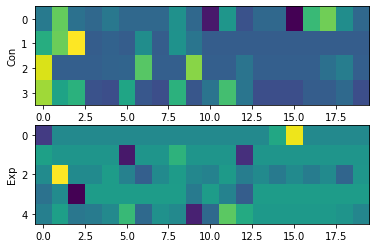

In [4]:
#Get name of directory where the data files and pickle file sits, and change to that directory for processing
dir_name = '/media/fastdata/brad_changepoint'
os.chdir(dir_name)

con_name = 'con_zscoreddiff_rearingduration.csv'
con_df = pd.read_csv(con_name,header=None)
con_data_mat = con_df.to_numpy()

exp_name = 'exp_zscoreddiff_rearingduration.csv'
exp_df = pd.read_csv(exp_name,header=None)
exp_data_mat = exp_df.to_numpy()


n_count_data = con_data_mat.shape[-1]
fig,ax = plt.subplots(2,1)
ax[0].imshow(con_data_mat,aspect='auto')
ax[0].set_ylabel('Con');
ax[1].imshow(exp_data_mat,aspect='auto')
ax[1].set_ylabel('Exp');

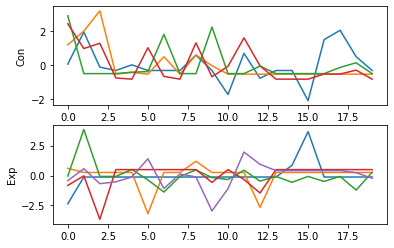

In [5]:
fig,ax = plt.subplots(2,1)
ax[0].plot(con_data_mat.T)
ax[0].set_ylabel('Con');
ax[1].plot(exp_data_mat.T)
ax[1].set_ylabel('Exp');

## Test Data

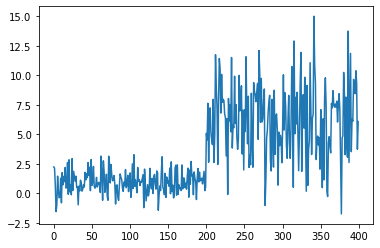

In [6]:
# Test data
length = 200
mu1 = 1
mu2 = 6
sigma1 = 1
sigma2 = 3

test_data = np.concatenate((stats.norm.rvs(mu1,sigma1,length),stats.norm.rvs(mu2,sigma2,length)))
plt.plot(test_data);


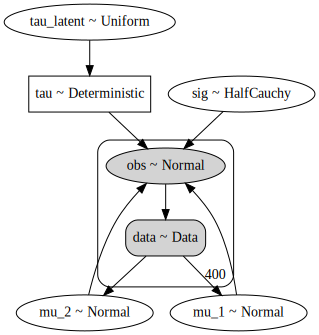

In [7]:
with pm.Model() as model:
    
    # Define shared "Data" holder to fit same model to different datasets 
    data = pm.Data("data", test_data)#con_data_mat[0])
    # Defining variables with priors
    alpha = data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1)
    sigma = pm.HalfCauchy('sig', 1)

    idx = np.arange(np.array(model["data"].get_value()).shape[-1])
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    mu_ = (1 - weight) * mu_1 + weight * mu_2

with model:
    observation = pm.Normal("obs", mu=mu_, sigma = sigma, observed=data)

pm.model_to_graphviz(model)

In [8]:
with model:
        # Switch out the observed dataset
        pm.set_data({"data": test_data})
        test_trace = pm.sample()#pm.sample(step = pm.Metropolis())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2772.55draws/s]


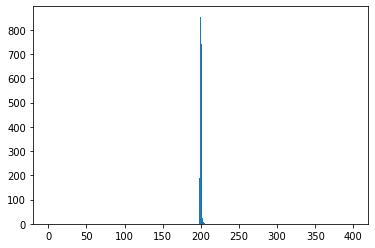

In [9]:
plt.hist(test_trace['tau'],np.arange(0,2*length));

## Actual Data

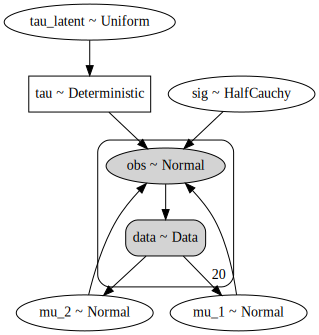

In [10]:
with pm.Model() as model:
    
    # Define shared "Data" holder to fit same model to different datasets 
    data = pm.Data("data", con_data_mat[0])
    # Defining variables with priors
    alpha = data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1)
    sigma = pm.HalfCauchy('sig', 1)

    idx = np.arange(np.array(model["data"].get_value()).shape[-1])
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    mu_ = (1 - weight) * mu_1 + weight * mu_2

with model:
    observation = pm.Normal("obs", mu=mu_, sigma = sigma, observed=data)

pm.model_to_graphviz(model)

In [11]:
# Generate one trace for each dataset
con_traces = []
for data_vals in con_data_mat:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        con_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))
        
# Generate one trace for each dataset
exp_traces = []
for data_vals in exp_data_mat:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        exp_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2360.77draws/s]
The acceptance probability does not match the target. It is 0.714101381062436, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7194057447238492, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2865.10draws/s]
The acceptance probability does not match the target. It is 0.9055350896222272, but should be close to 0.8. Try to increase the numb

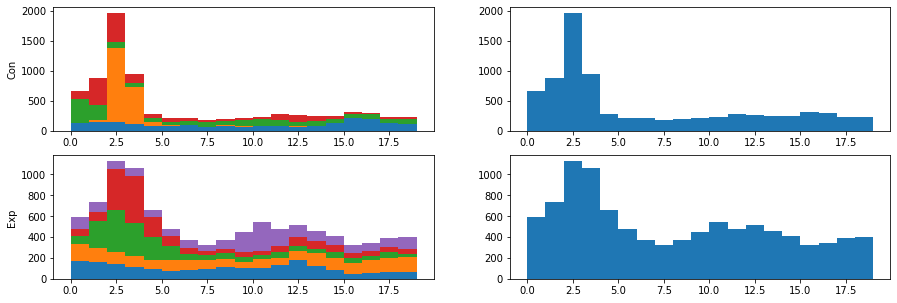

In [93]:
con_tau_array = np.array([this_trace["tau"] for this_trace in con_traces])
exp_tau_array = np.array([this_trace["tau"] for this_trace in exp_traces])

fig, ax = plt.subplots(2,2, figsize = (15,5))
ax[0,0].hist(con_tau_array.T, np.arange(20), stacked = 'true');
ax[0,1].hist(con_tau_array.flatten(), np.arange(20), stacked = 'true');
ax[1,0].hist(exp_tau_array.T, np.arange(20), stacked = 'true');
ax[1,1].hist(exp_tau_array.flatten(), np.arange(20), stacked = 'true');

ax[0,0].set_ylabel('Con');
ax[1,0].set_ylabel('Exp');

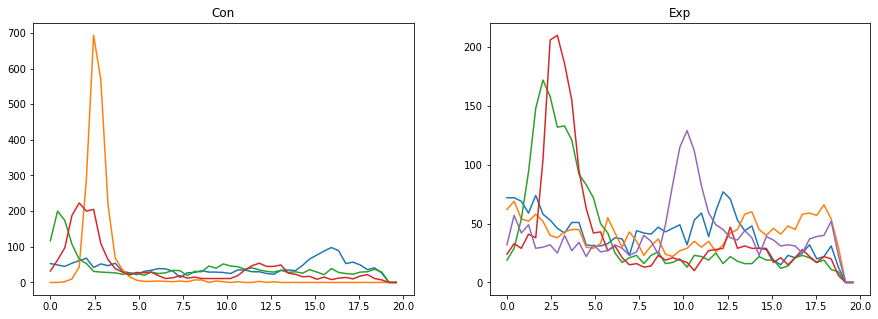

In [160]:
bins = np.linspace(0,20,50)
con_tau_hist = np.array([np.histogram(x, bins)[0] for x in con_tau_array])
exp_tau_hist = np.array([np.histogram(x, bins)[0] for x in exp_tau_array])

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(bins[:-1],con_tau_hist.T);
ax[1].plot(bins[:-1],exp_tau_hist.T);

ax[0].set_title('Con');
ax[1].set_title('Exp');

## Shuffled Data

In [97]:
shuffle_num = 50
con_shuffle_dat = np.array(\
                           [[np.random.permutation(data_vals) \
                             for data_vals in con_data_mat] for i in range(shuffle_num)])
exp_shuffle_dat = np.array(\
                           [[np.random.permutation(data_vals) \
                             for data_vals in exp_data_mat] for i in range(shuffle_num)])

In [98]:
con_inds = np.array(list(np.ndindex(con_shuffle_dat.shape[:-1])))
exp_inds = np.array(list(np.ndindex(exp_shuffle_dat.shape[:-1])))

In [22]:
# Generate one trace for each dataset
exp_shuffle_traces = []
for this_ind in tqdm(exp_inds):
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": exp_shuffle_dat[tuple(this_ind)]})
        exp_shuffle_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))
        
# Generate one trace for each dataset
con_shuffle_traces = []
for this_ind in tqdm(con_inds):
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": con_shuffle_dat[tuple(this_ind)]})
        con_shuffle_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))

  0%|          | 0/250 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2550.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
  0%|          | 1/250 [00:03<14:50,  3.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2259.78draws/s]
The number of effective samples is smaller than 25% for some parameters.
  1%|          | 2/250 [00:06<14:33,  3.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2055.50draws/s]
The number of effective samples is smaller than 25% for some parameters.
  2%|▏         | 5/250 [00:17<14:39,  3.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2158.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
  2%|▏         | 6/250 [00:21<14:59,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1957.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
  3%|▎         | 7/250 [00:25<14:57,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1995.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
  4%|▎         | 9/250 [00:33<15:07,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2100.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
  4%|▍         | 10/250 [00:36<14:47,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  4%|▍         | 11/250 [00:39<14:12,  3.57s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  5%|▍         | 12/250 [00:43<13:55,  3.51s/it]Auto-assignin

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2134.63draws/s]
The number of effective samples is smaller than 25% for some parameters.
  6%|▌         | 14/250 [00:50<14:01,  3.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2179.90draws/s]
The acceptance probability does not match the target. It is 0.8926654138909558, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5269337145087389, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
  6%|▌         | 15/250 [00:54<13:53,  3.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 job

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2047.09draws/s]
The acceptance probability does not match the target. It is 0.7171051140288597, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
  7%|▋         | 18/250 [01:05<14:05,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1998.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
  8%|▊         | 19/250 [01:09<14:30,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2007.52draws/s]
The number of effecti

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2564.04draws/s]
The acceptance probability does not match the target. It is 0.6858337057201787, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9162890180051789, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
  9%|▉         | 22/250 [01:19<13:50,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  9%|▉         | 23/250 [01:23<14:00,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2348.06draws/s]
The number of effective samples i

 10%|█         | 26/250 [01:34<13:49,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2252.67draws/s]
The acceptance probability does not match the target. It is 0.8870515962985062, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 11%|█         | 27/250 [01:38<13:28,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2218.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
 11%|█         | 28/250 [01:41<13:13,  3.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+ad

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1850.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
 12%|█▏        | 30/250 [01:49<13:31,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1988.27draws/s]
The number of effective samples is smaller than 25% for some parameters.
 12%|█▏        | 31/250 [01:53<13:27,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2095.01draws/s]
The acceptance probability does not match the target. It is 0.8812382204059079, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effecti

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1968.07draws/s]
The number of effective samples is smaller than 25% for some parameters.
 14%|█▎        | 34/250 [02:04<13:36,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1951.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
 14%|█▍        | 35/250 [02:08<13:55,  3.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1980.34draws/s]
The acceptance probability does not match the target. It is 0.6972574617356936, but should be close to 0.8. Try to increase the number of tuning steps.
 14%|█▍        | 36/2

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1814.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
 15%|█▌        | 38/250 [02:20<13:26,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 16%|█▌        | 39/250 [02:24<13:48,  3.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 16%|█▌        | 40/250 [02:28<13:32,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2097.83draws/s]
The acceptance probability does not match the target. It is 0.6798254895486272, but should be close to 0.8. Try to increase the numbe

 17%|█▋        | 42/250 [02:35<13:10,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2301.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
 17%|█▋        | 43/250 [02:38<12:42,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2013.67draws/s]
The number of effective samples is smaller than 25% for some parameters.
 18%|█▊        | 44/250 [02:42<12:37,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1853.27draws/s]
The number of effective samples is smaller than 25% for some parameters.
 18%|█▊        | 46/250 [02:50<13:11,  3.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2055.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
 19%|█▉        | 47/250 [02:54<12:50,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 19%|█▉        | 48/250 [02:57<12:36,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 20%|█▉        | 49/250 [03:01<12:16,  3.66s/it]Auto-assigni

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2128.25draws/s]
The acceptance probability does not match the target. It is 0.720925750746176, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 20%|██        | 50/250 [03:05<12:33,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2230.85draws/s]
The number of effective samples is smaller than 25% for some parameters.
 20%|██        | 51/250 [03:08<12:11,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1992.98draws/s]
The number of effectiv

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1891.68draws/s]
The acceptance probability does not match the target. It is 0.7007698618828739, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 22%|██▏       | 54/250 [03:19<12:09,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 22%|██▏       | 55/250 [03:23<11:51,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 22%|██▏       | 56/250 [03:26<11:36,  3.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:0

 23%|██▎       | 58/250 [03:34<11:41,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2171.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
 24%|██▎       | 59/250 [03:37<11:29,  3.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1965.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
 24%|██▍       | 60/250 [03:41<11:31,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2083.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
 25%|██▌       | 63/250 [03:52<11:25,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 26%|██▌       | 64/250 [03:56<11:03,  3.57s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1961.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
 26%|██▌       | 65/250 [04:00<11:34,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2199.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
 27%|██▋       | 67/250 [04:07<11:10,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2325.66draws/s]
The number of effective samples is smaller than 25% for some parameters.
 27%|██▋       | 68/250 [04:11<11:20,  3.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1817.09draws/s]
The number of effective samples is smaller than 25% for some parameters.
 28%|██▊       | 69/250 [04:15<11:23,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS usi

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2040.19draws/s]
The acceptance probability does not match the target. It is 0.6997856450293017, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6779760950048638, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 28%|██▊       | 71/250 [04:22<11:01,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1939.20draws/s]
The number of effective samples is smaller than 25% for some parameters.
 29%|██▉       | 72/250 [04:26<11:28,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 job

 30%|███       | 75/250 [04:37<10:44,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 30%|███       | 76/250 [04:40<10:23,  3.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 31%|███       | 77/250 [04:44<10:43,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 31%|███       | 78/250 [04:48<10:42,  3.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 32%|███▏      | 79/250 [04:52<10:22,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2125.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
 32%|███▏      | 80/250 [04:55<10:13,  3.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 32%|███▏      | 81/250 [04:59<10:34,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2410.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
 33%|███▎      | 82/250 [05:03<10:09,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2027.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
 34%|███▎      | 84/250 [05:10<10:02,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 34%|███▍      | 85/250 [05:14<10:22,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1911.36draws/s]
The number of effective samples is smaller than 25% for some parameters.
 34%|███▍      | 86/250 [05:18<10:19,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2155.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
 35%|███▌      | 88/250 [05:25<09:47,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1982.11draws/s]
The acceptance probability does not match the target. It is 0.7086220199484838, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 36%|███▌      | 89/250 [05:29<10:13,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2190.57draws/s]
The number of effecti

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2227.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
 37%|███▋      | 92/250 [05:39<09:20,  3.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2261.88draws/s]
The number of effective samples is smaller than 25% for some parameters.
 37%|███▋      | 93/250 [05:43<09:10,  3.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 38%|███▊      | 94/250 [05:47<09:25,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 38%|███▊      | 95/250 [05:50<09:16,  3.59s/it]Auto-assigni

 38%|███▊      | 96/250 [05:54<09:21,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2113.43draws/s]
The number of effective samples is smaller than 25% for some parameters.
 39%|███▉      | 97/250 [05:57<09:13,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1997.47draws/s]
The number of effective samples is smaller than 25% for some parameters.
 39%|███▉      | 98/250 [06:02<09:37,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

 40%|████      | 101/250 [06:12<09:08,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 41%|████      | 102/250 [06:17<09:40,  3.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2140.32draws/s]
The number of effective samples is smaller than 25% for some parameters.
 41%|████      | 103/250 [06:20<09:19,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 42%|████▏     | 104/250 [06:24<09:01,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chain

 42%|████▏     | 105/250 [06:27<08:38,  3.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1890.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
 42%|████▏     | 106/250 [06:31<08:44,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 43%|████▎     | 107/250 [06:35<09:01,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2020.69draws/s]
The number of effective samples is smaller than 25% for some parameters.
 43%|████▎     | 108/250 [06:39<08:51,  3.74s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2040.14draws/s]
The acceptance probability does not match the target. It is 0.7149013911118353, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7022443613673818, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6728975359018402, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 44%|████▎     | 109/250 [06:42<08:44,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1859.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
 44%|████▍ 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2005.63draws/s]
The acceptance probability does not match the target. It is 0.7040334918753117, but should be close to 0.8. Try to increase the number of tuning steps.
 45%|████▌     | 113/250 [06:58<08:43,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2069.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
 46%|████▌     | 114/250 [07:01<08:30,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1994.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
 46%|████▌     | 11

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1823.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
 47%|████▋     | 117/250 [07:13<08:35,  3.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2086.61draws/s]
The number of effective samples is smaller than 25% for some parameters.
 47%|████▋     | 118/250 [07:17<08:20,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2155.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
 48%|████▊     | 119/250 [07:20<08:05,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS 

 48%|████▊     | 121/250 [07:28<08:17,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 49%|████▉     | 122/250 [07:32<08:01,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2249.33draws/s]
The acceptance probability does not match the target. It is 0.6191937251173262, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 49%|████▉     | 123/250 [07:35<07:46,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<0

 50%|█████     | 125/250 [07:42<07:32,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2156.10draws/s]
The number of effective samples is smaller than 25% for some parameters.
 50%|█████     | 126/250 [07:47<07:51,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1960.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
 51%|█████     | 127/250 [07:50<07:45,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2121.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
 52%|█████▏    | 130/250 [08:01<07:25,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2027.72draws/s]
The number of effective samples is smaller than 25% for some parameters.
 52%|█████▏    | 131/250 [08:06<07:42,  3.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1998.07draws/s]
The number of effective samples is smaller tha

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1928.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
 54%|█████▎    | 134/250 [08:17<07:20,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2001.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
 54%|█████▍    | 135/250 [08:21<07:11,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2045.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
 54%|█████▍    | 1

 55%|█████▌    | 138/250 [08:32<06:54,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1913.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
 56%|█████▌    | 139/250 [08:36<06:52,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1932.05draws/s]
The acceptance probability does not match the target. It is 0.6638525036471483, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849600023451594, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2004.57draws/s]
The number of effective samples is smaller than 25% for some parameters.
 57%|█████▋    | 142/250 [08:48<06:59,  3.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2241.56draws/s]
The acceptance probability does not match the target. It is 0.7204511090335628, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 57%|█████▋    | 143/250 [08:51<06:42,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2211.04draws/s]
The acceptance prob

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2078.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
 58%|█████▊    | 146/250 [09:02<06:20,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2105.22draws/s]
The acceptance probability does not match the target. It is 0.7100911244315011, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7130512464860947, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 59%|█████▉    | 147/250 [09:06<06:35,  3.84s/it]Auto-assigning NUTS sampler...
Ini

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2280.07draws/s]
The acceptance probability does not match the target. It is 0.6631236050899016, but should be close to 0.8. Try to increase the number of tuning steps.
 60%|██████    | 150/250 [09:17<06:04,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2078.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
 60%|██████    | 151/250 [09:20<05:58,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2228.85draws/s]
The number o

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2182.43draws/s]
The number of effective samples is smaller than 25% for some parameters.
 62%|██████▏   | 154/250 [09:32<05:49,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1822.96draws/s]
The acceptance probability does not match the target. It is 0.7039840344909959, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 62%|██████▏   | 155/250 [09:35<05:52,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1897.50draws/s]
The acceptance prob

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2163.21draws/s]
The number of effective samples is smaller than 25% for some parameters.
 63%|██████▎   | 158/250 [09:47<05:51,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 64%|██████▎   | 159/250 [09:51<05:41,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 64%|██████▍   | 160/250 [09:54<05:28,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2502.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
 64%|██████▍   | 161/250 [09:57<05:14,  3.53s/it]Auto-ass

 65%|██████▍   | 162/250 [10:01<05:11,  3.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 65%|██████▌   | 163/250 [10:06<05:36,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 66%|██████▌   | 164/250 [10:10<05:34,  3.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 66%|██████▌   | 165/250 [10:13<05:24,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 2510/4000 [00:01<00:00, 2001.04draws/s]


 66%|██████▋   | 166/250 [10:17<05:19,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2031.69draws/s]
The acceptance probability does not match the target. It is 0.6387268855469734, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 67%|██████▋   | 167/250 [10:21<05:11,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 67%|██████▋   | 168/250 [10:25<05:25,  3.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<0

 68%|██████▊   | 170/250 [10:32<05:01,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2148.83draws/s]
The number of effective samples is smaller than 25% for some parameters.
 68%|██████▊   | 171/250 [10:36<04:52,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1963.47draws/s]
The number of effective samples is smaller than 25% for some parameters.
 69%|██████▉   | 172/250 [10:39<04:48,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1982.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
 70%|██████▉   | 174/250 [10:48<05:01,  3.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 70%|███████   | 175/250 [10:51<04:50,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2000.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
 70%|███████   | 176/250 [10:55<04:42,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 71%|███████   | 177/250 [10:59<04:39,  3.83s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1964.69draws/s]
The number of effective samples is smaller than 25% for some parameters.
 71%|███████   | 178/250 [11:03<04:32,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2078.73draws/s]
The number of effective samples is smaller than 25% for some parameters.
 72%|███████▏  | 179/250 [11:06<04:24,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 72%|███████▏  | 180/250 [11:10<04:30,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 72%|███████▏  | 181/250 [11:14<04:23,  3.82s/it]Auto-ass


 73%|███████▎  | 183/250 [11:21<04:09,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2161.42draws/s]
The number of effective samples is smaller than 25% for some parameters.
 74%|███████▎  | 184/250 [11:25<04:01,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2336.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
 74%|███████▍  | 185/250 [11:28<03:52,  3.57s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/

 75%|███████▍  | 187/250 [11:36<03:56,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 75%|███████▌  | 188/250 [11:40<03:45,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1853.85draws/s]
The acceptance probability does not match the target. It is 0.7022790718576531, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6394530255032006, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.699224854288749, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1942.16draws/s]
The acceptance probability does not match the target. It is 0.8797265605861708, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 76%|███████▋  | 191/250 [11:51<03:38,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2152.72draws/s]
The number of effective samples is smaller than 25% for some parameters.
 77%|███████▋  | 192/250 [11:55<03:46,  3.91s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 77%|███████▋  | 193/250 [11:59<03:43,  3.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1979.06draws/s]
The acceptance probability does not match the target. It is 0.7010608054078779, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 78%|███████▊  | 195/250 [12:07<03:30,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1704.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
 78%|███████▊  | 196/250 [12:11<03:29,  3.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2024.13draws/s]
The number of effec

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1856.66draws/s]
The acceptance probability does not match the target. It is 0.7186615854357201, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 79%|███████▉  | 198/250 [12:19<03:31,  4.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2110.83draws/s]
The acceptance probability does not match the target. It is 0.6943054114918745, but should be close to 0.8. Try to increase the number of tuning steps.
 80%|███████▉  | 199/250 [12:23<03:20,  3.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergence

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2056.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
 81%|████████  | 202/250 [12:34<02:59,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1977.35draws/s]
The acceptance probability does not match the target. It is 0.7122247102577595, but should be close to 0.8. Try to increase the number of tuning steps.
 81%|████████  | 203/250 [12:37<02:54,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1952.20draws/s]
The acceptance probability does not match the target. It is 0.6922495976533856, but should b

 82%|████████▏ | 206/250 [12:49<02:45,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 83%|████████▎ | 207/250 [12:53<02:40,  3.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1756.60draws/s]
The acceptance probability does not match the target. It is 0.6775977938166962, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 83%|████████▎ | 208/250 [12:57<02:39,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<0

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2013.76draws/s]
The number of effective samples is smaller than 25% for some parameters.
 84%|████████▍ | 210/250 [13:05<02:40,  4.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 84%|████████▍ | 211/250 [13:09<02:32,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1826.59draws/s]
The acceptance probability does not match the target. It is 0.8872781779132008, but should be close to 0.8. Try to increase the number of tuning steps.
 85%|████████▍ | 212/250 [13:12<02:28,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_late

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2037.41draws/s]
The acceptance probability does not match the target. It is 0.7039511113012334, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 86%|████████▌ | 214/250 [13:20<02:15,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1944.39draws/s]
The number of effective samples is smaller than 25% for some parameters.
 86%|████████▌ | 215/250 [13:23<02:10,  3.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2131.60draws/s]
The acceptance prob

 87%|████████▋ | 218/250 [13:35<02:01,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2048.10draws/s]
The number of effective samples is smaller than 25% for some parameters.
 88%|████████▊ | 219/250 [13:39<01:56,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1864.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
 88%|████████▊ | 220/250 [13:43<01:53,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 88%|████████▊ | 221/250 [13:46<01:47,  3.70s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2464.21draws/s]
The acceptance probability does not match the target. It is 0.5586454496984089, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8988602854157456, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8893605156134905, but should be close to 0.8. Try to increase the number of tuning steps.
 89%|████████▉ | 222/250 [13:49<01:40,  3.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2111.24draws/s]
The acceptance probability does not match the target. It is 0.6782741346376913, but should be close to 0.8. Try to increase the number of tuning steps.
The n

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2136.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
 90%|█████████ | 226/250 [14:05<01:28,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2109.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
 91%|█████████ | 227/250 [14:08<01:23,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2109.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
 91%|█████████ | 228/250 [14:12<01:19,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1817.89draws/s]
The acceptance probability does not match the target. It is 0.71838057218391, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7135884321263398, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 92%|█████████▏| 230/250 [14:20<01:18,  3.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 92%|█████████▏| 231/250 [14:24<01:12,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2070.71draws/s]
The number of effective samples i

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1811.49draws/s]
The acceptance probability does not match the target. It is 0.7047770314757621, but should be close to 0.8. Try to increase the number of tuning steps.
 94%|█████████▎| 234/250 [14:35<00:59,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2257.22draws/s]
The acceptance probability does not match the target. It is 0.8842926896508656, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 94%|█████████▍| 235/250 [14:38<00:54,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergence

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 96%|█████████▌| 239/250 [14:53<00:39,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2140.11draws/s]
The acceptance probability does not match the target. It is 0.9196797430747914, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8901256171508151, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 96%|█████████▌| 240/250 [14:57<00:36,  3.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|███

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2066.36draws/s]
The number of effective samples is smaller than 25% for some parameters.
 97%|█████████▋| 243/250 [15:09<00:26,  3.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2392.71draws/s]
The number of effective samples is smaller than 25% for some parameters.
 98%|█████████▊| 244/250 [15:12<00:22,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 98%|█████████▊| 245/250 [15:16<00:18,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2578.16draws/s]
The number of effective samples is smaller than 25% for some parameters.
 99%|█████████▉| 247/250 [15:23<00:10,  3.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1810.03draws/s]
The number of effective samples is smaller than 25% for some parameters.
 99%|█████████▉| 248/250 [15:27<00:07,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

100%|█████████▉| 249/250 [15:31<00:03,  3.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1853.28draws/s]
The number of effective samples is smaller than 25% for some parameters.
  0%|          | 1/200 [00:03<12:43,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1845.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
  1%|          | 2/200 [00:07<12:41,  3.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2009.42draws/s]
The acceptance probability does not match the target. It is 0.6888146982999268, but should be close to 0.8. Try to increase the number of tuning steps.
  2%|▏         | 3/200 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1931.76draws/s]
The number of effective samples is smaller than 25% for some parameters.
  2%|▎         | 5/200 [00:19<12:20,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2046.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
  3%|▎         | 6/200 [00:22<12:08,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1897.15draws/s]
The number of effective samples is smaller than 25% for some parameters.
  4%|▎         | 7/200 [00:27<13:10,  4.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using 

  4%|▍         | 9/200 [00:34<12:25,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1962.70draws/s]
The acceptance probability does not match the target. It is 0.7198424842802259, but should be close to 0.8. Try to increase the number of tuning steps.
  5%|▌         | 10/200 [00:38<12:12,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2201.83draws/s]
The number of effective samples is smaller than 25% for some parameters.
  6%|▌         | 11/200 [00:42<11:48,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2081.35draws/s]
The acceptance probability does not match the target. It is 0.911051145188255, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
  6%|▋         | 13/200 [00:49<11:42,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1798.87draws/s]
The number of effective samples is smaller than 25% for some parameters.
  7%|▋         | 14/200 [00:54<12:42,  4.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  8%|▊         | 15/200 [00:58<12:14,  3.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+ada

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1938.16draws/s]
The number of effective samples is smaller than 25% for some parameters.
  8%|▊         | 17/200 [01:05<11:39,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1868.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
  9%|▉         | 18/200 [01:09<11:36,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2123.28draws/s]
The acceptance probability does not match the target. It is 0.7001557793125343, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effecti

 10%|█         | 21/200 [01:21<12:05,  4.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2176.67draws/s]
The number of effective samples is smaller than 25% for some parameters.
 11%|█         | 22/200 [01:25<11:34,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1962.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
 12%|█▏        | 23/200 [01:28<11:23,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 12%|█▏        | 24/200 [01:32<11:06,  3.79s/it]Auto-assigni

 12%|█▎        | 25/200 [01:35<10:44,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2120.50draws/s]
The acceptance probability does not match the target. It is 0.6911339717383881, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 13%|█▎        | 26/200 [01:39<10:33,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 14%|█▎        | 27/200 [01:42<10:08,  3.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:0

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1853.66draws/s]
The acceptance probability does not match the target. It is 0.721542530800462, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 14%|█▍        | 29/200 [01:51<11:04,  3.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1814.75draws/s]
The number of effective samples is smaller than 25% for some parameters.
 15%|█▌        | 30/200 [01:55<11:03,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2004.93draws/s]
The number of effectiv

 16%|█▋        | 33/200 [02:06<10:19,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2171.75draws/s]
The acceptance probability does not match the target. It is 0.6540844366478175, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 17%|█▋        | 34/200 [02:09<10:06,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1831.84draws/s]
The acceptance probability does not match the target. It is 0.7191274862771533, but should be close to 0.8. Try to increase the number of tuning steps.
 18%|█▊        | 35/200 [02:14<11

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2198.82draws/s]
The number of effective samples is smaller than 25% for some parameters.
 18%|█▊        | 37/200 [02:21<10:23,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2185.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
 19%|█▉        | 38/200 [02:25<10:05,  3.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1964.05draws/s]
The number of effective samples is smaller than 25% for some parameters.
 20%|█▉        | 39/200 [02:29<10:01,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS usi

 20%|██        | 41/200 [02:36<09:46,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1793.82draws/s]
The number of effective samples is smaller than 25% for some parameters.
 21%|██        | 42/200 [02:40<09:53,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 22%|██▏       | 43/200 [02:45<10:35,  4.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 22%|██▏       | 44/200 [02:48<10:19,  3.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0

 22%|██▎       | 45/200 [02:52<10:08,  3.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2131.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
 23%|██▎       | 46/200 [02:56<09:49,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2022.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
 24%|██▎       | 47/200 [03:00<09:39,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 24%|██▍       | 48/200 [03:03<09:36,  3.79s/it]Auto-assigni

 24%|██▍       | 49/200 [03:07<09:18,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1980.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
 25%|██▌       | 50/200 [03:11<09:14,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1998.78draws/s]
The acceptance probability does not match the target. It is 0.6605134858586477, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 26%|██▌       | 51/200 [03:15<10:01,  4.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+ad

 26%|██▋       | 53/200 [03:23<09:28,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 27%|██▋       | 54/200 [03:27<09:20,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 28%|██▊       | 55/200 [03:30<09:04,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1944.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
 28%|██▊       | 56/200 [03:34<08:59,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1924.44draws/s]
The acceptance probability does not match the target. It is 0.898706890346102, but should be close to 0.8. Try to increase the number of tuning steps.
 29%|██▉       | 58/200 [03:41<08:52,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1976.63draws/s]
The number of effective samples is smaller than 25% for some parameters.
 30%|██▉       | 59/200 [03:46<09:34,  4.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 

 30%|███       | 61/200 [03:54<08:56,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1942.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
 31%|███       | 62/200 [03:57<08:48,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1875.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
 32%|███▏      | 63/200 [04:01<08:44,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

 32%|███▎      | 65/200 [04:09<08:40,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 33%|███▎      | 66/200 [04:13<08:27,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2040.86draws/s]
The number of effective samples is smaller than 25% for some parameters.
 34%|███▎      | 67/200 [04:17<09:06,  4.11s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2074.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
 34%|███▍      | 68/200 [04:21<08:42,  3.96s/it]Auto-assigni

The number of effective samples is smaller than 25% for some parameters.
 34%|███▍      | 69/200 [04:25<08:33,  3.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1702.18draws/s]
The acceptance probability does not match the target. It is 0.6993187372899575, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.695105926498539, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6146044048572346, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 35%|███▌      | 70/200 [04:29<08:34,  3.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using j

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1644.59draws/s]
The acceptance probability does not match the target. It is 0.7101631456299973, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 36%|███▋      | 73/200 [04:40<08:17,  3.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2089.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
 37%|███▋      | 74/200 [04:44<08:00,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1971.10draws/s]
The number of effecti

 38%|███▊      | 77/200 [04:57<08:24,  4.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1958.36draws/s]
The number of effective samples is smaller than 25% for some parameters.
 39%|███▉      | 78/200 [05:00<08:07,  3.99s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 40%|███▉      | 79/200 [05:04<07:58,  3.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2019.15draws/s]
The number of effective samples is smaller than 25% for some parameters.
 40%|████      | 80/200 [05:08<07:45,  3.88s/it]Auto-assigni

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2003.12draws/s]
The number of effective samples is smaller than 25% for some parameters.
 40%|████      | 81/200 [05:12<07:34,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1994.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
 41%|████      | 82/200 [05:15<07:25,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1939.18draws/s]
The number of effective samples is smaller than 25% for some parameters.
 42%|████▏     | 83/200 [05:19<07:20,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS usi

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1815.85draws/s]
The acceptance probability does not match the target. It is 0.6394343613475316, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 42%|████▎     | 85/200 [05:28<07:40,  4.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1959.67draws/s]
The number of effective samples is smaller than 25% for some parameters.
 43%|████▎     | 86/200 [05:32<07:28,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 44%|████▎     | 87/200 [05:35<07:11,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+ad

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1919.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
 44%|████▍     | 89/200 [05:42<06:56,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2010.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
 45%|████▌     | 90/200 [05:46<06:49,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1789.51draws/s]
The number of effective samples is smaller than 25% for some parameters.
 46%|████▌     | 91/200 [05:50<06:51,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS usi

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2158.03draws/s]
The number of effective samples is smaller than 25% for some parameters.
 46%|████▋     | 93/200 [05:58<06:57,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 47%|████▋     | 94/200 [06:02<06:46,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 48%|████▊     | 95/200 [06:06<06:37,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1839.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
 48%|████▊     | 96/200 [06:09<06:35,  3.81s/it]Auto-assigni

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2037.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
 48%|████▊     | 97/200 [06:13<06:27,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 49%|████▉     | 98/200 [06:17<06:26,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1872.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
 50%|████▉     | 99/200 [06:21<06:23,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2200.39draws/s]
The number of effective samples is smaller than 25% for some parameters.
 50%|█████     | 101/200 [06:29<06:42,  4.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 51%|█████     | 102/200 [06:33<06:21,  3.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2627.23draws/s]
The acceptance probability does not match the target. It is 0.6429828256691618, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8896691034841193, but should be close to 0.8. Try to increase the number of tuning steps.
 52%|█████▏    | 103/200 [06:36

 53%|█████▎    | 106/200 [06:47<05:40,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2000.40draws/s]
The number of effective samples is smaller than 25% for some parameters.
 54%|█████▎    | 107/200 [06:50<05:38,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 54%|█████▍    | 108/200 [06:54<05:39,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2364.66draws/s]
The number of effective samples is smaller than 25% for some parameters.
 55%|█████▍    | 109/200 [06:59<06:01,  3.97s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1981.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
 55%|█████▌    | 110/200 [07:02<05:50,  3.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 56%|█████▌    | 111/200 [07:06<05:40,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1788.74draws/s]
The acceptance probability does not match the target. It is 0.701777800509349, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6473542230689125, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1907.21draws/s]
The number of effective samples is smaller than 25% for some parameters.
 57%|█████▋    | 114/200 [07:18<05:27,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1900.00draws/s]
The acceptance probability does not match the target. It is 0.7147204665278226, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 57%|█████▊    | 115/200 [07:21<05:23,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1826.02draws/s]
The acceptance prob

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2044.92draws/s]
The number of effective samples is smaller than 25% for some parameters.
 59%|█████▉    | 118/200 [07:34<05:41,  4.17s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 60%|█████▉    | 119/200 [07:38<05:27,  4.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1961.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
 60%|██████    | 120/200 [07:42<05:17,  3.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_lat

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1709.15draws/s]
The number of effective samples is smaller than 25% for some parameters.
 61%|██████    | 122/200 [07:49<05:08,  3.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2000.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
 62%|██████▏   | 123/200 [07:53<04:57,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1946.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
 62%|██████▏   | 1

 62%|██████▎   | 125/200 [08:00<04:40,  3.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 63%|██████▎   | 126/200 [08:04<04:32,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1988.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
 64%|██████▎   | 127/200 [08:09<04:57,  4.08s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2077.88draws/s]
The number of effective samples is smaller than 25% for some parameters.
 64%|██████▍   | 128/200 [08:13<04:44,  3.96s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1763.55draws/s]
The acceptance probability does not match the target. It is 0.7087606937116524, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 65%|██████▌   | 130/200 [08:20<04:36,  3.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1936.76draws/s]
The number of effective samples is smaller than 25% for some parameters.
 66%|██████▌   | 131/200 [08:24<04:28,  3.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1800.75draws/s]
The acceptance prob

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2157.37draws/s]
The number of effective samples is smaller than 25% for some parameters.
 66%|██████▋   | 133/200 [08:32<04:13,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2021.89draws/s]
The acceptance probability does not match the target. It is 0.4809936770267284, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 67%|██████▋   | 134/200 [08:35<04:07,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2212.74draws/s]
The number of effec

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1962.21draws/s]
The acceptance probability does not match the target. It is 0.7101151141422988, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 69%|██████▉   | 138/200 [08:51<03:58,  3.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1829.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
 70%|██████▉   | 139/200 [08:55<03:56,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 70%|███████   | 140/200 [08:59<03:50,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2195.30draws/s]
The number of effective samples is smaller than 25% for some parameters.
 71%|███████   | 142/200 [09:06<03:34,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 72%|███████▏  | 143/200 [09:09<03:30,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2013.63draws/s]
The number of effective samples is smaller than 25% for some parameters.
 72%|███████▏  | 144/200 [09:13<03:26,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1821.47draws/s]
The number of effective samples is smaller than 25% for some parameters.
 73%|███████▎  | 146/200 [09:22<03:41,  4.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1827.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
 74%|███████▎  | 147/200 [09:26<03:34,  4.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 74%|███████▍  | 148/200 [09:30<03:25,  3.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1930.08draws/s]
The acceptance probability does not match the target. It is 0.7020427410578755, but should be close to 0.8. Try to increase the number of tuning steps.
 75%|███████▌  | 150/200 [09:38<03:13,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1921.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
 76%|███████▌  | 151/200 [09:41<03:08,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1866.80draws/s]
The number of effective samples is smaller than 25% for some parameters.
 76%|███████▌  | 15

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1924.82draws/s]
The number of effective samples is smaller than 25% for some parameters.
 77%|███████▋  | 154/200 [09:53<02:53,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1866.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
 78%|███████▊  | 155/200 [09:58<03:09,  4.21s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 78%|███████▊  | 156/200 [10:01<02:54,  3.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1990.56draws/s]
The acceptance probability does not match the target. It is 0.8849896886374273, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 79%|███████▉  | 158/200 [10:09<02:41,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2379.08draws/s]
The acceptance probability does not match the target. It is 0.6620327402465288, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.606973041293207, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 80%|███████

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1987.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
 81%|████████  | 162/200 [10:23<02:20,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1898.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
 82%|████████▏ | 163/200 [10:27<02:17,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1936.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
 82%|████████▏ | 164/200 [10:32<02:28,  4.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2272.11draws/s]
The number of effective samples is smaller than 25% for some parameters.
 83%|████████▎ | 166/200 [10:39<02:10,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2114.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
 84%|████████▎ | 167/200 [10:43<02:04,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1956.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
 84%|████████▍ | 168/200 [10:46<02:00,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1932.80draws/s]
The acceptance probability does not match the target. It is 0.6642372496167811, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.696805986487501, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 85%|████████▌ | 170/200 [10:54<01:52,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 86%|████████▌ | 171/200 [10:58<01:49,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 86%|████████▌ | 172/200 [11:02<01:45,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag..

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1933.38draws/s]
The acceptance probability does not match the target. It is 0.7193897774123768, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6326375641338615, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 87%|████████▋ | 174/200 [11:10<01:48,  4.16s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 88%|████████▊ | 175/200 [11:14<01:40,  4.00s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2059.59draws/s]
The number of effective samples

 89%|████████▉ | 178/200 [11:25<01:24,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2191.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
 90%|████████▉ | 179/200 [11:29<01:18,  3.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 90%|█████████ | 180/200 [11:32<01:14,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1840.17draws/s]
The acceptance probability does not match the target. It is 0.7164015505812633, but should be close to 0.8. Try to increase the nu

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2052.26draws/s]
The acceptance probability does not match the target. It is 0.6533310177935248, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 91%|█████████ | 182/200 [11:40<01:06,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2054.00draws/s]
The acceptance probability does not match the target. It is 0.6940895097863183, but should be close to 0.8. Try to increase the number of tuning steps.
 92%|█████████▏| 183/200 [11:44<01:02,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 92%|█████████▏| 184/200 [11:49

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1726.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
 93%|█████████▎| 186/200 [11:56<00:56,  4.03s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1873.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
 94%|█████████▎| 187/200 [12:00<00:51,  3.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 94%|█████████▍| 188/200 [12:04<00:47,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2017.33draws/s]
The acceptance probability does not match the target. It is 0.6987912483189447, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 95%|█████████▌| 190/200 [12:12<00:38,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 96%|█████████▌| 191/200 [12:15<00:33,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 96%|█████████▌| 192/200 [12:19<00:29,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<0

 97%|█████████▋| 194/200 [12:28<00:24,  4.15s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1884.72draws/s]
The number of effective samples is smaller than 25% for some parameters.
 98%|█████████▊| 195/200 [12:32<00:20,  4.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 98%|█████████▊| 196/200 [12:35<00:15,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1872.32draws/s]
The acceptance probability does not match the target. It is 0.6610857517331236, but should be close to 0.8. Try to increase the nu

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1829.61draws/s]
The number of effective samples is smaller than 25% for some parameters.
 99%|█████████▉| 198/200 [12:43<00:07,  3.91s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

100%|█████████▉| 199/200 [12:47<00:03,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

100%|██████████| 200/200 [12:50<00:00,  3.85s/it]


In [145]:
exp_diff_shuffle_tau_array = np.array([this_trace["tau"] for this_trace in exp_shuffle_traces])
con_diff_shuffle_tau_array = np.array([this_trace["tau"] for this_trace in con_shuffle_traces])
np.save('exp_diff_shuffle_tau_array',exp_diff_shuffle_tau_array)
np.save('con_diff_shuffle_tau_array',con_diff_shuffle_tau_array)
exp_diff_shuffle_tau_hists = np.array([np.histogram(x, bins)[0] for x in exp_diff_shuffle_tau_array])
con_diff_shuffle_tau_hists = np.array([np.histogram(x, bins)[0] for x in con_diff_shuffle_tau_array])

In [146]:
con_shuffle_hist_array = np.zeros((*con_shuffle_dat.shape[:2],con_diff_shuffle_tau_hists.shape[-1]))
for num, this_ind in enumerate(con_inds):
    con_shuffle_hist_array[tuple(this_ind)] = con_diff_shuffle_tau_hists[num]
exp_shuffle_hist_array = np.zeros((*exp_shuffle_dat.shape[:2],exp_diff_shuffle_tau_hists.shape[-1]))
for num, this_ind in enumerate(exp_inds):
    exp_shuffle_hist_array[tuple(this_ind)] = exp_diff_shuffle_tau_hists[num]

In [147]:
mean_shuffle_con = np.mean(con_shuffle_hist_array,axis=0)
mean_shuffle_exp = np.mean(exp_shuffle_hist_array,axis=0)
std_shuffle_con = np.std(con_shuffle_hist_array,axis=0)
std_shuffle_exp = np.std(exp_shuffle_hist_array,axis=0)

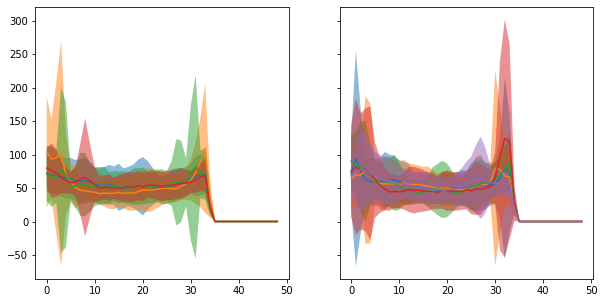

In [148]:
fig,ax = plt.subplots(1,2, figsize = (10,5),sharey=True)
x = np.arange(con_shuffle_hist_array.shape[-1])
for mean, std in zip(mean_shuffle_con, std_shuffle_con):
    ax[0].fill_between(x, mean+std, mean-std, alpha = 0.5)
    ax[0].plot(x, mean)
for mean, std in zip(mean_shuffle_exp, std_shuffle_exp):
    ax[1].fill_between(x, mean+std, mean-std, alpha = 0.5)
    ax[1].plot(x, mean)

In [149]:
# Calculate confidence intervals for each animal, for each timepoint
con_shuffle_hist_array = np.moveaxis(con_shuffle_hist_array,0,-1)
exp_shuffle_hist_array = np.moveaxis(exp_shuffle_hist_array,0,-1)

In [150]:
shuffle_num = 50
con_shuffle_dat = np.array(\
                           [[np.random.permutation(data_vals) \
                             for data_vals in con_data_mat] for i in range(shuffle_num)])
exp_shuffle_dat = np.array(\
                           [[np.random.permutation(data_vals) \
                             for data_vals in exp_data_mat] for i in range(shuffle_num)])

In [151]:
con_inds = np.array(list(np.ndindex(con_shuffle_dat.shape[:-1])))
exp_inds = np.array(list(np.ndindex(exp_shuffle_dat.shape[:-1])))

In [22]:
# Generate one trace for each dataset
exp_shuffle_traces = []
for this_ind in tqdm(exp_inds):
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": exp_shuffle_dat[tuple(this_ind)]})
        exp_shuffle_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))
        
# Generate one trace for each dataset
con_shuffle_traces = []
for this_ind in tqdm(con_inds):
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": con_shuffle_dat[tuple(this_ind)]})
        con_shuffle_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))

  0%|          | 0/250 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2550.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
  0%|          | 1/250 [00:03<14:50,  3.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2259.78draws/s]
The number of effective samples is smaller than 25% for some parameters.
  1%|          | 2/250 [00:06<14:33,  3.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2055.50draws/s]
The number of effective samples is smaller than 25% for some parameters.
  2%|▏         | 5/250 [00:17<14:39,  3.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2158.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
  2%|▏         | 6/250 [00:21<14:59,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1957.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
  3%|▎         | 7/250 [00:25<14:57,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2134.63draws/s]
The number of effective samples is smaller than 25% for some parameters.
  6%|▌         | 14/250 [00:50<14:01,  3.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2179.90draws/s]
The acceptance probability does not match the target. It is 0.8926654138909558, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5269337145087389, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
  6%|▌         | 15/250 [00:54<13:53,  3.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 job

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2564.04draws/s]
The acceptance probability does not match the target. It is 0.6858337057201787, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9162890180051789, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
  9%|▉         | 22/250 [01:19<13:50,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  9%|▉         | 23/250 [01:23<14:00,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2348.06draws/s]
The number of effective samples i

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1850.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
 12%|█▏        | 30/250 [01:49<13:31,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1988.27draws/s]
The number of effective samples is smaller than 25% for some parameters.
 12%|█▏        | 31/250 [01:53<13:27,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2095.01draws/s]
The acceptance probability does not match the target. It is 0.8812382204059079, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effecti

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1814.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
 15%|█▌        | 38/250 [02:20<13:26,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 16%|█▌        | 39/250 [02:24<13:48,  3.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 16%|█▌        | 40/250 [02:28<13:32,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2097.83draws/s]
The acceptance probability does not match the target. It is 0.6798254895486272, but should be close to 0.8. Try to increase the numbe

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1853.27draws/s]
The number of effective samples is smaller than 25% for some parameters.
 18%|█▊        | 46/250 [02:50<13:11,  3.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2055.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
 19%|█▉        | 47/250 [02:54<12:50,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 19%|█▉        | 48/250 [02:57<12:36,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 20%|█▉        | 49/250 [03:01<12:16,  3.66s/it]Auto-assigni

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1891.68draws/s]
The acceptance probability does not match the target. It is 0.7007698618828739, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 22%|██▏       | 54/250 [03:19<12:09,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 22%|██▏       | 55/250 [03:23<11:51,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 22%|██▏       | 56/250 [03:26<11:36,  3.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:0

 23%|██▎       | 58/250 [03:34<11:41,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2171.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
 24%|██▎       | 59/250 [03:37<11:29,  3.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1965.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
 24%|██▍       | 60/250 [03:41<11:31,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2083.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
 25%|██▌       | 63/250 [03:52<11:25,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 26%|██▌       | 64/250 [03:56<11:03,  3.57s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1961.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
 26%|██▌       | 65/250 [04:00<11:34,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2040.19draws/s]
The acceptance probability does not match the target. It is 0.6997856450293017, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6779760950048638, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 28%|██▊       | 71/250 [04:22<11:01,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1939.20draws/s]
The number of effective samples is smaller than 25% for some parameters.
 29%|██▉       | 72/250 [04:26<11:28,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 job

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2125.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
 32%|███▏      | 80/250 [04:55<10:13,  3.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 32%|███▏      | 81/250 [04:59<10:34,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2410.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
 33%|███▎      | 82/250 [05:03<10:09,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2027.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
 34%|███▎      | 84/250 [05:10<10:02,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 34%|███▍      | 85/250 [05:14<10:22,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1911.36draws/s]
The number of effective samples is smaller than 25% for some parameters.
 34%|███▍      | 86/250 [05:18<10:19,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2227.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
 37%|███▋      | 92/250 [05:39<09:20,  3.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2261.88draws/s]
The number of effective samples is smaller than 25% for some parameters.
 37%|███▋      | 93/250 [05:43<09:10,  3.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 38%|███▊      | 94/250 [05:47<09:25,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 38%|███▊      | 95/250 [05:50<09:16,  3.59s/it]Auto-assigni

 38%|███▊      | 96/250 [05:54<09:21,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2113.43draws/s]
The number of effective samples is smaller than 25% for some parameters.
 39%|███▉      | 97/250 [05:57<09:13,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1997.47draws/s]
The number of effective samples is smaller than 25% for some parameters.
 39%|███▉      | 98/250 [06:02<09:37,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

 40%|████      | 101/250 [06:12<09:08,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 41%|████      | 102/250 [06:17<09:40,  3.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2140.32draws/s]
The number of effective samples is smaller than 25% for some parameters.
 41%|████      | 103/250 [06:20<09:19,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 42%|████▏     | 104/250 [06:24<09:01,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 42%|████▏     |

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2040.14draws/s]
The acceptance probability does not match the target. It is 0.7149013911118353, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7022443613673818, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6728975359018402, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 44%|████▎     | 109/250 [06:42<08:44,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1859.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
 44%|████▍ 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1823.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
 47%|████▋     | 117/250 [07:13<08:35,  3.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2086.61draws/s]
The number of effective samples is smaller than 25% for some parameters.
 47%|████▋     | 118/250 [07:17<08:20,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2155.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
 48%|████▊     | 119/250 [07:20<08:05,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS 

 50%|█████     | 125/250 [07:42<07:32,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2156.10draws/s]
The number of effective samples is smaller than 25% for some parameters.
 50%|█████     | 126/250 [07:47<07:51,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1960.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
 51%|█████     | 127/250 [07:50<07:45,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2121.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
 52%|█████▏    | 130/250 [08:01<07:25,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2027.72draws/s]
The number of effective samples is smaller than 25% for some parameters.
 52%|█████▏    | 131/250 [08:06<07:42,  3.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1998.07draws/s]
The number of effective samples is smaller tha

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1928.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
 54%|█████▎    | 134/250 [08:17<07:20,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2001.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
 54%|█████▍    | 135/250 [08:21<07:11,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2045.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
 54%|█████▍    | 1

 55%|█████▌    | 138/250 [08:32<06:54,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1913.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
 56%|█████▌    | 139/250 [08:36<06:52,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1932.05draws/s]
The acceptance probability does not match the target. It is 0.6638525036471483, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849600023451594, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2078.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
 58%|█████▊    | 146/250 [09:02<06:20,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2105.22draws/s]
The acceptance probability does not match the target. It is 0.7100911244315011, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7130512464860947, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 59%|█████▉    | 147/250 [09:06<06:35,  3.84s/it]Auto-assigning NUTS sampler...
Ini

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2280.07draws/s]
The acceptance probability does not match the target. It is 0.6631236050899016, but should be close to 0.8. Try to increase the number of tuning steps.
 60%|██████    | 150/250 [09:17<06:04,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2078.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
 60%|██████    | 151/250 [09:20<05:58,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2228.85draws/s]
The number o

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2182.43draws/s]
The number of effective samples is smaller than 25% for some parameters.
 62%|██████▏   | 154/250 [09:32<05:49,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1822.96draws/s]
The acceptance probability does not match the target. It is 0.7039840344909959, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 62%|██████▏   | 155/250 [09:35<05:52,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1897.50draws/s]
The acceptance prob

 65%|██████▍   | 162/250 [10:01<05:11,  3.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 65%|██████▌   | 163/250 [10:06<05:36,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 66%|██████▌   | 164/250 [10:10<05:34,  3.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 66%|██████▌   | 165/250 [10:13<05:24,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 66%|██████▋   | 166/250 [10:17<05:19,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_l

 68%|██████▊   | 170/250 [10:32<05:01,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2148.83draws/s]
The number of effective samples is smaller than 25% for some parameters.
 68%|██████▊   | 171/250 [10:36<04:52,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1963.47draws/s]
The number of effective samples is smaller than 25% for some parameters.
 69%|██████▉   | 172/250 [10:39<04:48,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1964.69draws/s]
The number of effective samples is smaller than 25% for some parameters.
 71%|███████   | 178/250 [11:03<04:32,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2078.73draws/s]
The number of effective samples is smaller than 25% for some parameters.
 72%|███████▏  | 179/250 [11:06<04:24,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 72%|███████▏  | 180/250 [11:10<04:30,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 72%|███████▏  | 181/250 [11:14<04:23,  3.82s/it]Auto-ass


 73%|███████▎  | 183/250 [11:21<04:09,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2161.42draws/s]
The number of effective samples is smaller than 25% for some parameters.
 74%|███████▎  | 184/250 [11:25<04:01,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2336.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
 74%|███████▍  | 185/250 [11:28<03:52,  3.57s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/

 75%|███████▍  | 187/250 [11:36<03:56,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 75%|███████▌  | 188/250 [11:40<03:45,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1853.85draws/s]
The acceptance probability does not match the target. It is 0.7022790718576531, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6394530255032006, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.699224854288749, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1979.06draws/s]
The acceptance probability does not match the target. It is 0.7010608054078779, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 78%|███████▊  | 195/250 [12:07<03:30,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1704.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
 78%|███████▊  | 196/250 [12:11<03:29,  3.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2024.13draws/s]
The number of effec

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2056.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
 81%|████████  | 202/250 [12:34<02:59,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1977.35draws/s]
The acceptance probability does not match the target. It is 0.7122247102577595, but should be close to 0.8. Try to increase the number of tuning steps.
 81%|████████  | 203/250 [12:37<02:54,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1952.20draws/s]
The acceptance probability does not match the target. It is 0.6922495976533856, but should b

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2013.76draws/s]
The number of effective samples is smaller than 25% for some parameters.
 84%|████████▍ | 210/250 [13:05<02:40,  4.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 84%|████████▍ | 211/250 [13:09<02:32,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1826.59draws/s]
The acceptance probability does not match the target. It is 0.8872781779132008, but should be close to 0.8. Try to increase the number of tuning steps.
 85%|████████▍ | 212/250 [13:12<02:28,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_late

 87%|████████▋ | 218/250 [13:35<02:01,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2048.10draws/s]
The number of effective samples is smaller than 25% for some parameters.
 88%|████████▊ | 219/250 [13:39<01:56,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1864.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
 88%|████████▊ | 220/250 [13:43<01:53,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 88%|████████▊ | 221/250 [13:46<01:47,  3.70s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2136.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
 90%|█████████ | 226/250 [14:05<01:28,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2109.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
 91%|█████████ | 227/250 [14:08<01:23,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2109.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
 91%|█████████ | 228/250 [14:12<01:19,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1811.49draws/s]
The acceptance probability does not match the target. It is 0.7047770314757621, but should be close to 0.8. Try to increase the number of tuning steps.
 94%|█████████▎| 234/250 [14:35<00:59,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2257.22draws/s]
The acceptance probability does not match the target. It is 0.8842926896508656, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 94%|█████████▍| 235/250 [14:38<00:54,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergence

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 96%|█████████▌| 239/250 [14:53<00:39,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2140.11draws/s]
The acceptance probability does not match the target. It is 0.9196797430747914, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8901256171508151, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 96%|█████████▌| 240/250 [14:57<00:36,  3.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|███

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2066.36draws/s]
The number of effective samples is smaller than 25% for some parameters.
 97%|█████████▋| 243/250 [15:09<00:26,  3.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2392.71draws/s]
The number of effective samples is smaller than 25% for some parameters.
 98%|█████████▊| 244/250 [15:12<00:22,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 98%|█████████▊| 245/250 [15:16<00:18,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2578.16draws/s]
The number of effective samples is smaller than 25% for some parameters.
 99%|█████████▉| 247/250 [15:23<00:10,  3.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1810.03draws/s]
The number of effective samples is smaller than 25% for some parameters.
 99%|█████████▉| 248/250 [15:27<00:07,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

100%|█████████▉| 249/250 [15:31<00:03,  3.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1931.76draws/s]
The number of effective samples is smaller than 25% for some parameters.
  2%|▎         | 5/200 [00:19<12:20,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2046.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
  3%|▎         | 6/200 [00:22<12:08,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1897.15draws/s]
The number of effective samples is smaller than 25% for some parameters.
  4%|▎         | 7/200 [00:27<13:10,  4.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2081.35draws/s]
The acceptance probability does not match the target. It is 0.911051145188255, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
  6%|▋         | 13/200 [00:49<11:42,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1798.87draws/s]
The number of effective samples is smaller than 25% for some parameters.
  7%|▋         | 14/200 [00:54<12:42,  4.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  8%|▊         | 15/200 [00:58<12:14,  3.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+ada

 10%|█         | 21/200 [01:21<12:05,  4.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2176.67draws/s]
The number of effective samples is smaller than 25% for some parameters.
 11%|█         | 22/200 [01:25<11:34,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1962.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
 12%|█▏        | 23/200 [01:28<11:23,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 12%|█▏        | 24/200 [01:32<11:06,  3.79s/it]Auto-assigni

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1853.66draws/s]
The acceptance probability does not match the target. It is 0.721542530800462, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 14%|█▍        | 29/200 [01:51<11:04,  3.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1814.75draws/s]
The number of effective samples is smaller than 25% for some parameters.
 15%|█▌        | 30/200 [01:55<11:03,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2004.93draws/s]
The number of effectiv

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2198.82draws/s]
The number of effective samples is smaller than 25% for some parameters.
 18%|█▊        | 37/200 [02:21<10:23,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2185.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
 19%|█▉        | 38/200 [02:25<10:05,  3.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1964.05draws/s]
The number of effective samples is smaller than 25% for some parameters.
 20%|█▉        | 39/200 [02:29<10:01,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS usi

 22%|██▎       | 45/200 [02:52<10:08,  3.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2131.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
 23%|██▎       | 46/200 [02:56<09:49,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2022.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
 24%|██▎       | 47/200 [03:00<09:39,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 24%|██▍       | 48/200 [03:03<09:36,  3.79s/it]Auto-assigni

 24%|██▍       | 49/200 [03:07<09:18,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1980.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
 25%|██▌       | 50/200 [03:11<09:14,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1998.78draws/s]
The acceptance probability does not match the target. It is 0.6605134858586477, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 26%|██▌       | 51/200 [03:15<10:01,  4.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+ad

 26%|██▋       | 53/200 [03:23<09:28,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 27%|██▋       | 54/200 [03:27<09:20,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 28%|██▊       | 55/200 [03:30<09:04,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1944.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
 28%|██▊       | 56/200 [03:34<08:59,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1924.44draws/s]
The acceptance probability does not match the target. It is 0.898706890346102, but should be close to 0.8. Try to increase the number of tuning steps.
 29%|██▉       | 58/200 [03:41<08:52,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1976.63draws/s]
The number of effective samples is smaller than 25% for some parameters.
 30%|██▉       | 59/200 [03:46<09:34,  4.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 

 30%|███       | 61/200 [03:54<08:56,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1942.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
 31%|███       | 62/200 [03:57<08:48,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1875.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
 32%|███▏      | 63/200 [04:01<08:44,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

The number of effective samples is smaller than 25% for some parameters.
 34%|███▍      | 69/200 [04:25<08:33,  3.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1702.18draws/s]
The acceptance probability does not match the target. It is 0.6993187372899575, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.695105926498539, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6146044048572346, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 35%|███▌      | 70/200 [04:29<08:34,  3.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using j

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1644.59draws/s]
The acceptance probability does not match the target. It is 0.7101631456299973, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 36%|███▋      | 73/200 [04:40<08:17,  3.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2089.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
 37%|███▋      | 74/200 [04:44<08:00,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1971.10draws/s]
The number of effecti

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2003.12draws/s]
The number of effective samples is smaller than 25% for some parameters.
 40%|████      | 81/200 [05:12<07:34,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1994.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
 41%|████      | 82/200 [05:15<07:25,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1939.18draws/s]
The number of effective samples is smaller than 25% for some parameters.
 42%|████▏     | 83/200 [05:19<07:20,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS usi

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1919.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
 44%|████▍     | 89/200 [05:42<06:56,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2010.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
 45%|████▌     | 90/200 [05:46<06:49,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1789.51draws/s]
The number of effective samples is smaller than 25% for some parameters.
 46%|████▌     | 91/200 [05:50<06:51,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS usi

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2037.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
 48%|████▊     | 97/200 [06:13<06:27,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 49%|████▉     | 98/200 [06:17<06:26,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1872.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
 50%|████▉     | 99/200 [06:21<06:23,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

 53%|█████▎    | 106/200 [06:47<05:40,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2000.40draws/s]
The number of effective samples is smaller than 25% for some parameters.
 54%|█████▎    | 107/200 [06:50<05:38,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 54%|█████▍    | 108/200 [06:54<05:39,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2364.66draws/s]
The number of effective samples is smaller than 25% for some parameters.
 55%|█████▍    | 109/200 [06:59<06:01,  3.97s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1907.21draws/s]
The number of effective samples is smaller than 25% for some parameters.
 57%|█████▋    | 114/200 [07:18<05:27,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1900.00draws/s]
The acceptance probability does not match the target. It is 0.7147204665278226, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 57%|█████▊    | 115/200 [07:21<05:23,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1826.02draws/s]
The acceptance prob

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2044.92draws/s]
The number of effective samples is smaller than 25% for some parameters.
 59%|█████▉    | 118/200 [07:34<05:41,  4.17s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 60%|█████▉    | 119/200 [07:38<05:27,  4.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1961.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
 60%|██████    | 120/200 [07:42<05:17,  3.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_lat

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1709.15draws/s]
The number of effective samples is smaller than 25% for some parameters.
 61%|██████    | 122/200 [07:49<05:08,  3.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2000.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
 62%|██████▏   | 123/200 [07:53<04:57,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1946.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
 62%|██████▏   | 1

 62%|██████▎   | 125/200 [08:00<04:40,  3.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 63%|██████▎   | 126/200 [08:04<04:32,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1988.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
 64%|██████▎   | 127/200 [08:09<04:57,  4.08s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2077.88draws/s]
The number of effective samples is smaller than 25% for some parameters.
 64%|██████▍   | 128/200 [08:13<04:44,  3.96s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1763.55draws/s]
The acceptance probability does not match the target. It is 0.7087606937116524, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 65%|██████▌   | 130/200 [08:20<04:36,  3.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1936.76draws/s]
The number of effective samples is smaller than 25% for some parameters.
 66%|██████▌   | 131/200 [08:24<04:28,  3.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1800.75draws/s]
The acceptance prob

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1962.21draws/s]
The acceptance probability does not match the target. It is 0.7101151141422988, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 69%|██████▉   | 138/200 [08:51<03:58,  3.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1829.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
 70%|██████▉   | 139/200 [08:55<03:56,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 70%|███████   | 140/200 [08:59<03:50,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1821.47draws/s]
The number of effective samples is smaller than 25% for some parameters.
 73%|███████▎  | 146/200 [09:22<03:41,  4.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1827.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
 74%|███████▎  | 147/200 [09:26<03:34,  4.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 74%|███████▍  | 148/200 [09:30<03:25,  3.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1924.82draws/s]
The number of effective samples is smaller than 25% for some parameters.
 77%|███████▋  | 154/200 [09:53<02:53,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1866.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
 78%|███████▊  | 155/200 [09:58<03:09,  4.21s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 78%|███████▊  | 156/200 [10:01<02:54,  3.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1987.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
 81%|████████  | 162/200 [10:23<02:20,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1898.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
 82%|████████▏ | 163/200 [10:27<02:17,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1936.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
 82%|████████▏ | 164/200 [10:32<02:28,  4.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1932.80draws/s]
The acceptance probability does not match the target. It is 0.6642372496167811, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.696805986487501, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 85%|████████▌ | 170/200 [10:54<01:52,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 86%|████████▌ | 171/200 [10:58<01:49,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 86%|████████▌ | 172/200 [11:02<01:45,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag..

 89%|████████▉ | 178/200 [11:25<01:24,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2191.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
 90%|████████▉ | 179/200 [11:29<01:18,  3.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 90%|█████████ | 180/200 [11:32<01:14,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1840.17draws/s]
The acceptance probability does not match the target. It is 0.7164015505812633, but should be close to 0.8. Try to increase the nu

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1726.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
 93%|█████████▎| 186/200 [11:56<00:56,  4.03s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1873.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
 94%|█████████▎| 187/200 [12:00<00:51,  3.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 94%|█████████▍| 188/200 [12:04<00:47,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

 97%|█████████▋| 194/200 [12:28<00:24,  4.15s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1884.72draws/s]
The number of effective samples is smaller than 25% for some parameters.
 98%|█████████▊| 195/200 [12:32<00:20,  4.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 98%|█████████▊| 196/200 [12:35<00:15,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1872.32draws/s]
The acceptance probability does not match the target. It is 0.6610857517331236, but should be close to 0.8. Try to increase the nu

In [152]:
exp_diff_shuffle_tau_array = np.array([this_trace["tau"] for this_trace in exp_shuffle_traces])
con_diff_shuffle_tau_array = np.array([this_trace["tau"] for this_trace in con_shuffle_traces])
np.save('exp_diff_shuffle_tau_array',exp_diff_shuffle_tau_array)
np.save('con_diff_shuffle_tau_array',con_diff_shuffle_tau_array)
exp_diff_shuffle_tau_hists = np.array([np.histogram(x, bins)[0] for x in exp_diff_shuffle_tau_array])
con_diff_shuffle_tau_hists = np.array([np.histogram(x, bins)[0] for x in con_diff_shuffle_tau_array])

In [153]:
con_shuffle_hist_array = np.zeros((*con_shuffle_dat.shape[:2],con_diff_shuffle_tau_hists.shape[-1]))
for num, this_ind in enumerate(con_inds):
    con_shuffle_hist_array[tuple(this_ind)] = con_diff_shuffle_tau_hists[num]
exp_shuffle_hist_array = np.zeros((*exp_shuffle_dat.shape[:2],exp_diff_shuffle_tau_hists.shape[-1]))
for num, this_ind in enumerate(exp_inds):
    exp_shuffle_hist_array[tuple(this_ind)] = exp_diff_shuffle_tau_hists[num]

In [154]:
mean_shuffle_con = np.mean(con_shuffle_hist_array,axis=0)
mean_shuffle_exp = np.mean(exp_shuffle_hist_array,axis=0)
std_shuffle_con = np.std(con_shuffle_hist_array,axis=0)
std_shuffle_exp = np.std(exp_shuffle_hist_array,axis=0)

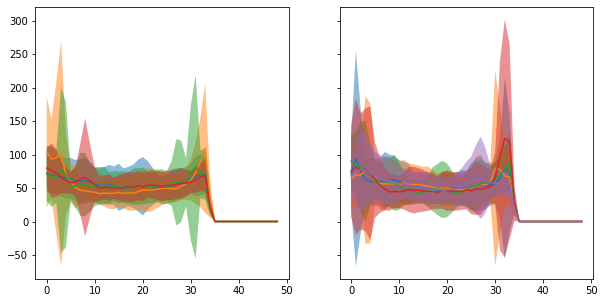

In [155]:
fig,ax = plt.subplots(1,2, figsize = (10,5),sharey=True)
x = np.arange(con_shuffle_hist_array.shape[-1])
for mean, std in zip(mean_shuffle_con, std_shuffle_con):
    ax[0].fill_between(x, mean+std, mean-std, alpha = 0.5)
    ax[0].plot(x, mean)
for mean, std in zip(mean_shuffle_exp, std_shuffle_exp):
    ax[1].fill_between(x, mean+std, mean-std, alpha = 0.5)
    ax[1].plot(x, mean)

In [156]:
# Calculate confidence intervals for each animal, for each timepoint
con_shuffle_hist_array = np.moveaxis(con_shuffle_hist_array,0,-1)
exp_shuffle_hist_array = np.moveaxis(exp_shuffle_hist_array,0,-1)

In [162]:
## Only looking for values HIGHER than control. NOT INTERESTED in below control

con_cis = np.zeros(con_shuffle_hist_array.shape[:-1], dtype = np.object)
con_cis_sig = np.zeros(con_cis.shape)
alpha = 0.05
wanted_percs = (100*(alpha/2),100*(1-(alpha)/2)) 
for animal_num,animal in enumerate(con_shuffle_hist_array):
    for time_num,time in enumerate(animal):
        ci_bounds = np.percentile(animal.flatten(), wanted_percs)
        con_cis[animal_num,time_num] = ci_bounds
        condition = con_tau_hist[animal_num,time_num] > ci_bounds[1]
        if condition:
            con_cis_sig[animal_num,time_num] = 1
            
exp_cis = np.zeros(exp_shuffle_hist_array.shape[:-1], dtype = np.object)
exp_cis_sig = np.zeros(exp_cis.shape)
wanted_percs = (100*(alpha/2),100*(1-(alpha)/2)) 
for animal_num,animal in enumerate(exp_shuffle_hist_array):
    for time_num,time in enumerate(animal):
        ci_bounds = np.percentile(animal.flatten(), wanted_percs)
        exp_cis[animal_num,time_num] = ci_bounds
        expdition = exp_tau_hist[animal_num,time_num] > ci_bounds[1]
        if expdition:
            exp_cis_sig[animal_num,time_num] = 1

Text(0.5, 1.0, 'Experimental')

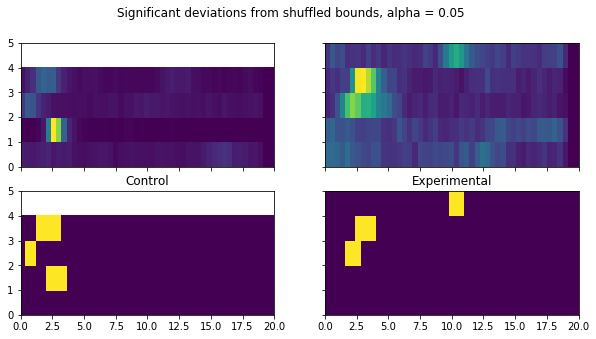

In [165]:
fig, ax = plt.subplots(2,2, figsize = (10,5),sharey=True, sharex=True)
ax[0,0].pcolormesh(bins, range(con_tau_hist.shape[0]+1), con_tau_hist)#, aspect = 'auto')
ax[0,1].pcolormesh(bins, range(exp_tau_hist.shape[0]+1), exp_tau_hist)#, aspect = 'auto')

plt.suptitle(f'Significant deviations from shuffled bounds, alpha = {alpha}')
ax[1,0].pcolormesh(bins, range(con_tau_hist.shape[0]+1), con_cis_sig)#, aspect = 'auto')
ax[1,0].set_title('Control')
ax[1,1].pcolormesh(bins, range(exp_tau_hist.shape[0]+1), exp_cis_sig)#, aspect = 'auto')
ax[1,1].set_title('Experimental')

In [166]:
## Only looking for values HIGHER than control. NOT INTERESTED in below control

con_cis = np.zeros(con_shuffle_hist_array.shape[:-1], dtype = np.object)
con_cis_sig = np.zeros(con_cis.shape)
alpha = 0.01
wanted_percs = (100*(alpha/2),100*(1-(alpha)/2)) 
for animal_num,animal in enumerate(con_shuffle_hist_array):
    for time_num,time in enumerate(animal):
        ci_bounds = np.percentile(animal.flatten(), wanted_percs)
        con_cis[animal_num,time_num] = ci_bounds
        condition = con_tau_hist[animal_num,time_num] > ci_bounds[1]
        if condition:
            con_cis_sig[animal_num,time_num] = 1
            
exp_cis = np.zeros(exp_shuffle_hist_array.shape[:-1], dtype = np.object)
exp_cis_sig = np.zeros(exp_cis.shape)
wanted_percs = (100*(alpha/2),100*(1-(alpha)/2)) 
for animal_num,animal in enumerate(exp_shuffle_hist_array):
    for time_num,time in enumerate(animal):
        ci_bounds = np.percentile(animal.flatten(), wanted_percs)
        exp_cis[animal_num,time_num] = ci_bounds
        expdition = exp_tau_hist[animal_num,time_num] > ci_bounds[1]
        if expdition:
            exp_cis_sig[animal_num,time_num] = 1

Text(0.5, 1.0, 'Experimental')

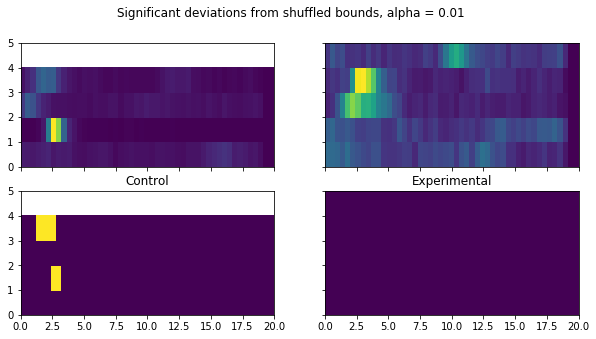

In [167]:
fig, ax = plt.subplots(2,2, figsize = (10,5),sharey=True, sharex=True)
ax[0,0].pcolormesh(bins, range(con_tau_hist.shape[0]+1), con_tau_hist)#, aspect = 'auto')
ax[0,1].pcolormesh(bins, range(exp_tau_hist.shape[0]+1), exp_tau_hist)#, aspect = 'auto')

plt.suptitle(f'Significant deviations from shuffled bounds, alpha = {alpha}')
ax[1,0].pcolormesh(bins, range(con_tau_hist.shape[0]+1), con_cis_sig)#, aspect = 'auto')
ax[1,0].set_title('Control')
ax[1,1].pcolormesh(bins, range(exp_tau_hist.shape[0]+1), exp_cis_sig)#, aspect = 'auto')
ax[1,1].set_title('Experimental')

# == Chop off Initial Transint ==

In [16]:
## What if we take out the first 5 minutes to avoid the transient in the beginning?

In [169]:
con_data_mat_cut = con_data_mat[:,5:]
exp_data_mat_cut = exp_data_mat[:,5:]
bins_cut = np.linspace(5,20,50)

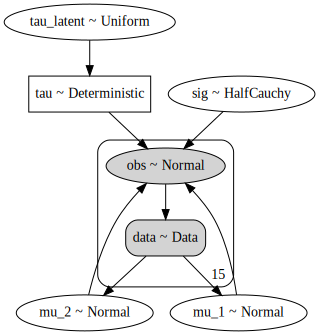

In [121]:
with pm.Model() as model_cut:
    
    # Define shared "Data" holder to fit same model to different datasets 
    data = pm.Data("data", con_data_mat_cut[0])
    # Defining variables with priors
    alpha = data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1)
    sigma = pm.HalfCauchy('sig', 1)

    idx = np.arange(np.array(model_cut["data"].get_value()).shape[-1])
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    mu_ = (1 - weight) * mu_1 + weight * mu_2


    observation = pm.Normal("obs", mu=mu_, sigma = sigma, observed=data)

pm.model_to_graphviz(model_cut)

In [35]:
# Generate one trace for each dataset
con_traces_cut = []
for data_vals in con_data_mat_cut:
    with model_cut:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        con_traces_cut.append(pm.sample())#pm.sample(step = pm.Metropolis()))
        
# Generate one trace for each dataset
exp_traces_cut = []
for data_vals in exp_data_mat_cut:
    with model_cut:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        exp_traces_cut.append(pm.sample())#pm.sample(step = pm.Metropolis()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1862.64draws/s]
The acceptance probability does not match the target. It is 0.7180911317170716, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8789684535885813, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2031.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████

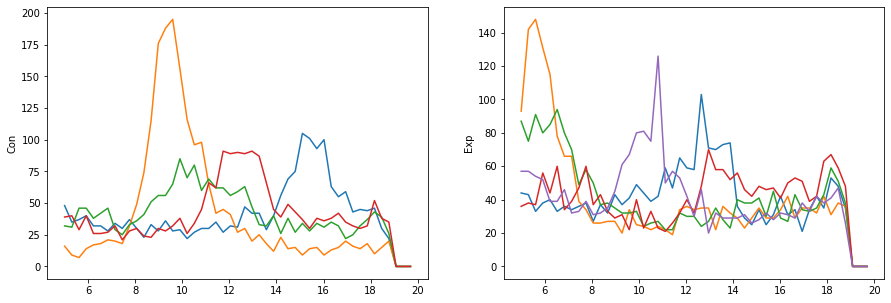

In [170]:
con_tau_array = np.array([this_trace["tau"] for this_trace in con_traces_cut])+5
exp_tau_array = np.array([this_trace["tau"] for this_trace in exp_traces_cut])+5
con_tau_hist = np.array([np.histogram(x, bins_cut)[0] for x in con_tau_array])
exp_tau_hist = np.array([np.histogram(x, bins_cut)[0] for x in exp_tau_array])

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(bins_cut[:-1],con_tau_hist.T);
ax[1].plot(bins_cut[:-1],exp_tau_hist.T);

ax[0].set_ylabel('Con');
ax[1].set_ylabel('Exp');

In [171]:
shuffle_num = 50
con_shuffle_dat = np.array(\
                           [[np.random.permutation(data_vals) \
                             for data_vals in con_data_mat_cut] for i in range(shuffle_num)])
exp_shuffle_dat = np.array(\
                           [[np.random.permutation(data_vals) \
                             for data_vals in exp_data_mat_cut] for i in range(shuffle_num)])

In [172]:
con_inds = np.array(list(np.ndindex(con_shuffle_dat.shape[:-1])))
exp_inds = np.array(list(np.ndindex(exp_shuffle_dat.shape[:-1])))

In [42]:
# Generate one trace for each dataset
exp_shuffle_traces = []
for this_ind in tqdm(exp_inds):
    with model_cut:
        # Switch out the observed dataset
        pm.set_data({"data": exp_shuffle_dat[tuple(this_ind)]})
        exp_shuffle_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))
        
# Generate one trace for each dataset
con_shuffle_traces = []
for this_ind in tqdm(con_inds):
    with model_cut:
        # Switch out the observed dataset
        pm.set_data({"data": con_shuffle_dat[tuple(this_ind)]})
        con_shuffle_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))

  0%|          | 0/250 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2002.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
  0%|          | 1/250 [00:03<15:39,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2099.47draws/s]
The number of effective samples is smaller than 25% for some parameters.
  1%|          | 2/250 [00:07<15:25,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:


Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2195.07draws/s]
The number of effective samples is smaller than 25% for some parameters.
  2%|▏         | 5/250 [00:18<14:56,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1905.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
  2%|▏         | 6/250 [00:24<17:28,  4.30s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2230.12draws/s]
The number of effective samples is smaller than 25% for some parameters.
  3%|▎         | 7/250 [00:27<16:27,  4.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using

  4%|▎         | 9/250 [00:35<15:36,  3.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  4%|▍         | 10/250 [00:38<15:11,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2063.21draws/s]
The number of effective samples is smaller than 25% for some parameters.
  4%|▍         | 11/250 [00:42<14:56,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2249.32draws/s]
The number of effective samples is smaller than 25% for some parameters.
  5%|▍         | 12/250 [00:46<15:51,  4.00s/it]Auto-assignin

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1970.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
  5%|▌         | 13/250 [00:50<15:29,  3.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  6%|▌         | 14/250 [00:53<14:40,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  6%|▌         | 15/250 [00:57<14:21,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  6%|▋         | 16/250 [01:01<14:27,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1976.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
  7%|▋         | 18/250 [01:08<14:15,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2079.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
  8%|▊         | 19/250 [01:13<15:16,  3.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  8%|▊         | 20/250 [01:16<14:29,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

  9%|▉         | 22/250 [01:23<14:06,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2061.72draws/s]
The number of effective samples is smaller than 25% for some parameters.
  9%|▉         | 23/250 [01:27<13:57,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 10%|▉         | 24/250 [01:31<13:45,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2012.40draws/s]
The acceptance probability does not match the target. It is 0.7175496970489771, but should be close to 0.8. Try to increase the numbe

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2045.15draws/s]
The acceptance probability does not match the target. It is 0.6923033602843343, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6995286356147065, but should be close to 0.8. Try to increase the number of tuning steps.
 10%|█         | 26/250 [01:39<14:52,  3.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 11%|█         | 27/250 [01:42<14:08,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2132.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
 11%|█         | 28/250 [01:46<13

NUTS: [tau_latent, sig, mu_2, mu_1]

 12%|█▏        | 31/250 [01:57<13:16,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 13%|█▎        | 32/250 [02:01<14:17,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2079.85draws/s]
The number of effective samples is smaller than 25% for some parameters.
 13%|█▎        | 33/250 [02:05<13:56,  3.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2068.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
 14%|█▎        | 34/250

 14%|█▍        | 35/250 [02:12<13:30,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2251.03draws/s]
The acceptance probability does not match the target. It is 0.6401636926481795, but should be close to 0.8. Try to increase the number of tuning steps.
 14%|█▍        | 36/250 [02:16<13:07,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2039.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
 15%|█▍        | 37/250 [02:19<13:03,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent,

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1901.46draws/s]
The acceptance probability does not match the target. It is 0.7202330023377103, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 16%|█▌        | 39/250 [02:28<13:59,  3.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 16%|█▌        | 40/250 [02:31<13:16,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2070.89draws/s]
The number of effective samples is smaller than 25% for some parameters.
 16%|█▋        | 41/250 [02:35<13:03,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+ad

 17%|█▋        | 43/250 [02:42<13:02,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1895.25draws/s]
The acceptance probability does not match the target. It is 0.7051453647508936, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 18%|█▊        | 44/250 [02:46<13:00,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 18%|█▊        | 45/250 [02:50<12:38,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 18%|█▊        | 46/250 [02:54<13:32,  3.98s/it]Auto-assigning NUTS samp

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2348.54draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 19%|█▉        | 48/250 [03:01<12:40,  3.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1981.51draws/s]
The number of effective samples is smaller than 25% for some parameters.
 20%|█▉        | 49/250 [03:05<12:36,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2202.79draws/s]
The number of effective samples is smaller than 25% for

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2087.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
 21%|██        | 52/250 [03:16<12:07,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2013.97draws/s]
The number of effective samples is smaller than 25% for some parameters.
 21%|██        | 53/250 [03:20<12:03,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 22%|██▏       | 54/250 [03:24<12:59,  3.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 22%|██▏       | 55/250 [03:28<12:29,  3.84s/it]Auto-assigni

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2018.52draws/s]
The number of effective samples is smaller than 25% for some parameters.
 22%|██▏       | 56/250 [03:32<12:17,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 23%|██▎       | 57/250 [03:35<12:02,  3.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1824.86draws/s]
The number of effective samples is smaller than 25% for some parameters.
 23%|██▎       | 58/250 [03:39<12:08,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 24%|██▍       | 61/250 [03:51<12:25,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2269.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
 25%|██▍       | 62/250 [03:54<11:53,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2130.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
 25%|██▌       | 63/250 [03:58<11:38,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent

 26%|██▌       | 65/250 [04:05<11:19,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 26%|██▋       | 66/250 [04:09<11:00,  3.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 27%|██▋       | 67/250 [04:12<11:02,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 27%|██▋       | 68/250 [04:17<11:36,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2093.98draws/s]
The acceptance probability does not match the target. It is 0.8833687855088517, but should be

 28%|██▊       | 70/250 [04:24<11:09,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2248.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
 28%|██▊       | 71/250 [04:27<10:53,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2203.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
 29%|██▉       | 72/250 [04:31<10:43,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1826.39draws/s]
The acceptance probability does not match the target. It is 0.6985673048317148, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6340460074575985, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 30%|██▉       | 74/250 [04:38<10:52,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 30%|███       | 75/250 [04:42<10:30,  3.60s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2536.31draws/s]
The acceptance probability does n

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2106.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
 31%|███       | 78/250 [04:53<10:37,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2158.81draws/s]
The acceptance probability does not match the target. It is 0.70462399990024, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 32%|███▏      | 79/250 [04:57<10:27,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 32%|███▏      | 80/250 [05:00<10:14,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adap

 33%|███▎      | 83/250 [05:12<11:00,  3.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 34%|███▎      | 84/250 [05:16<10:29,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2243.80draws/s]
The number of effective samples is smaller than 25% for some parameters.
 34%|███▍      | 85/250 [05:19<10:11,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 34%|███▍      | 86/250 [05:23<10:09,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0

 35%|███▍      | 87/250 [05:26<09:48,  3.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1986.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
 35%|███▌      | 88/250 [05:30<09:49,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2369.16draws/s]
The number of effective samples is smaller than 25% for some parameters.
 36%|███▌      | 89/250 [05:33<09:34,  3.57s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 36%|███▌      | 90/250 [05:37<09:36,  3.61s/it]Auto-assigni

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2157.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
 37%|███▋      | 92/250 [05:46<10:14,  3.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2072.87draws/s]
The number of effective samples is smaller than 25% for some parameters.
 37%|███▋      | 93/250 [05:49<09:59,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1928.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
 38%|███▊      | 94/250 [05:53<09:53,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS usi

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2082.43draws/s]
The number of effective samples is smaller than 25% for some parameters.
 38%|███▊      | 96/250 [06:01<09:37,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 39%|███▉      | 97/250 [06:04<09:26,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1757.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
 39%|███▉      | 98/250 [06:08<09:34,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

 40%|████      | 100/250 [06:17<09:51,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2106.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
 40%|████      | 101/250 [06:20<09:32,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 41%|████      | 102/250 [06:24<09:19,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2007.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
 41%|████      | 103/250 [06:28<09:13,  3.76s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2065.09draws/s]
The number of effective samples is smaller than 25% for some parameters.
 42%|████▏     | 104/250 [06:31<09:04,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2258.93draws/s]
The number of effective samples is smaller than 25% for some parameters.
 42%|████▏     | 105/250 [06:35<08:48,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 42%|████▏     | 106/250 [06:38<08:37,  3.60s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2075.73draws/s]
The number of effective samples is smaller than 25% for some parameters.
 43%|████▎     | 108/250 [06:47<09:08,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2223.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
 44%|████▎     | 109/250 [06:50<08:50,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 44%|████▍     | 110/250 [06:53<08:31,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 44%|████▍     | 111/250 [06:57<08:20,  3.60s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2043.90draws/s]
The acceptance probability does not match the target. It is 0.7162111172713549, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 45%|████▌     | 113/250 [07:04<08:09,  3.57s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2323.77draws/s]
The number of effective samples is smaller than 25% for some parameters.
 46%|████▌     | 114/250 [07:07<07:59,  3.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 46%|████▌     | 115/250 [07:12<08:51,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter

 47%|████▋     | 117/250 [07:19<08:06,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2079.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
 47%|████▋     | 118/250 [07:23<08:02,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1974.39draws/s]
The number of effective samples is smaller than 25% for some parameters.
 48%|████▊     | 119/250 [07:27<08:03,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 48%|████▊     | 120/250 [07:30<07:47,  3.60s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1941.46draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
 49%|████▉     | 123/250 [07:41<07:39,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 50%|████▉     | 124/250 [07:45<08:11,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2129.40draws/s]
The acceptance probability does not match the target. It is 0.6661996215659244, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 50%|█████     | 125/250 [07:49<07:55,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS us

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1988.15draws/s]
The acceptance probability does not match the target. It is 0.5873505531880203, but should be close to 0.8. Try to increase the number of tuning steps.
 51%|█████     | 128/250 [08:00<07:27,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1884.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
 52%|█████▏    | 129/250 [08:03<07:29,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2147.72draws/s]
The number o

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2181.02draws/s]
The acceptance probability does not match the target. It is 0.6282892055583943, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8862577884115711, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5751239674901091, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 53%|█████▎    | 132/250 [08:15<07:44,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2027.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2016.16draws/s]
The acceptance probability does not match the target. It is 0.7054845808291312, but should be close to 0.8. Try to increase the number of tuning steps.
 54%|█████▍    | 136/250 [08:30<07:08,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1957.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
 55%|█████▍    | 137/250 [08:34<07:04,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2236.57draws/s]
The number of effective samples is smaller than 25% for some parameters.
 55%|█████▌    | 13

 56%|█████▌    | 140/250 [08:44<06:40,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2407.93draws/s]
The acceptance probability does not match the target. It is 0.7030310568342916, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 56%|█████▋    | 141/250 [08:49<07:14,  3.99s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2406.87draws/s]
The number of effective samples is smaller than 25% for some parameters.
 57%|█████▋    | 142/250 [08:53<06:50,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1930.39draws/s]
The number of effective samples is smaller than 25% for some parameters.
 58%|█████▊    | 144/250 [09:00<06:37,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 58%|█████▊    | 145/250 [09:03<06:24,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2194.69draws/s]
The acceptance probability does not match the target. It is 0.8877382463155613, but should be close to 0.8. Try to increase the number of tuning steps.
 58%|█████▊    | 146/250 [09:07<06:16,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_late

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2136.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
 60%|█████▉    | 149/250 [09:19<06:43,  3.99s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 60%|██████    | 150/250 [09:22<06:24,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 60%|██████    | 151/250 [09:26<06:11,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 61%|██████    | 152/250 [09:30<06:02,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chain

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2146.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
 61%|██████    | 153/250 [09:33<05:55,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1981.34draws/s]
The acceptance probability does not match the target. It is 0.6996573372498724, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 62%|██████▏   | 154/250 [09:37<05:53,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1935.75draws/s]
The number of effec

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1999.57draws/s]
The number of effective samples is smaller than 25% for some parameters.
 63%|██████▎   | 158/250 [09:53<06:10,  4.03s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2048.62draws/s]
The number of effective samples is smaller than 25% for some parameters.
 64%|██████▎   | 159/250 [09:56<05:57,  3.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2456.21draws/s]
The acceptance probability does not match the target. It is 0.9412501564841317, but should 

 65%|██████▍   | 162/250 [10:07<05:21,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2123.69draws/s]
The acceptance probability does not match the target. It is 0.705597930805718, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 65%|██████▌   | 163/250 [10:10<05:16,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2087.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
 66%|██████▌   | 164/250 [10:14<05:12,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2093.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
 66%|██████▋   | 166/250 [10:21<05:00,  3.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2223.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
 67%|██████▋   | 167/250 [10:26<05:30,  3.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2293.42draws/s]
The number of effective samples is smaller than 25% for some parameters.
 67%|██████▋   | 168/250 [10:29<05:13,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2240.42draws/s]
The acceptance probability does not match the target. It is 0.8875490657685311, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6737173062612666, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 68%|██████▊   | 171/250 [10:40<04:51,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 69%|██████▉   | 172/250 [10:44<04:51,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2082.83draws/s]
The number of effective samples

 70%|███████   | 175/250 [10:55<04:30,  3.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2184.27draws/s]
The number of effective samples is smaller than 25% for some parameters.
 70%|███████   | 176/250 [10:58<04:24,  3.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2461.60draws/s]
The acceptance probability does not match the target. It is 0.9026927320449474, but should be close to 0.8. Try to increase the number of tuning steps.
 71%|███████   | 177/250 [11:03<04:46,  3.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_late

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1985.29draws/s]
The acceptance probability does not match the target. It is 0.6863201943365457, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6302574606944173, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 72%|███████▏  | 179/250 [11:11<04:34,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 72%|███████▏  | 180/250 [11:14<04:28,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2165.24draws/s]
The acceptance probability does

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2027.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
 73%|███████▎  | 183/250 [11:25<04:06,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2106.50draws/s]
The number of effective samples is smaller than 25% for some parameters.
 74%|███████▎  | 184/250 [11:29<04:01,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 74%|███████▍  | 185/250 [11:32<03:57,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 74%|███████▍  | 186/250 [11:37<04:19,  4.05s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2110.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
 75%|███████▌  | 188/250 [11:44<03:56,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2226.82draws/s]
The number of effective samples is smaller than 25% for some parameters.
 76%|███████▌  | 189/250 [11:48<03:47,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 76%|███████▌  | 190/250 [11:52<03:43,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 76%|███████▋  | 191/250 [11:55<03:38,  3.70s/it]Auto-ass

 77%|███████▋  | 192/250 [11:59<03:35,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2150.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
 77%|███████▋  | 193/250 [12:03<03:28,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2095.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
 78%|███████▊  | 194/250 [12:06<03:24,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 78%|███████▊  | 195/250 [12:11<03:43,  4.05s/it]Auto-ass

 78%|███████▊  | 196/250 [12:15<03:32,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 79%|███████▉  | 197/250 [12:19<03:24,  3.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1992.39draws/s]
The number of effective samples is smaller than 25% for some parameters.
 79%|███████▉  | 198/250 [12:22<03:19,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 80%|███████▉  | 199/250 [12:26<03:12,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 80%|████████  |

 80%|████████  | 201/250 [12:33<02:59,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1898.36draws/s]
The number of effective samples is smaller than 25% for some parameters.
 81%|████████  | 202/250 [12:37<02:57,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1969.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
 81%|████████  | 203/250 [12:41<02:54,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

 82%|████████▏ | 205/250 [12:49<03:03,  4.08s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2131.97draws/s]
The acceptance probability does not match the target. It is 0.8796816830212223, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875185706926147, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 82%|████████▏ | 206/250 [12:53<02:52,  3.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 83%|████████▎ | 207/250 [12:56<02:44,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag.

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1878.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
 84%|████████▎ | 209/250 [13:04<02:33,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2040.39draws/s]
The acceptance probability does not match the target. It is 0.7114858916612913, but should be close to 0.8. Try to increase the number of tuning steps.
 84%|████████▍ | 210/250 [13:07<02:29,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2175.81draws/s]
The acceptance probability does not match the target. It is 0.7140331628552306, but should b

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2098.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
 85%|████████▌ | 213/250 [13:18<02:14,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2091.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
 86%|████████▌ | 214/250 [13:22<02:10,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 86%|████████▌ | 215/250 [13:27<02:22,  4.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1969.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
 87%|████████▋ | 218/250 [13:37<01:59,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2042.13draws/s]
The acceptance probability does not match the target. It is 0.6934208900370884, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 88%|████████▊ | 219/250 [13:41<01:55,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2190.50draws/s]
The acceptance prob

 89%|████████▉ | 222/250 [13:52<01:44,  3.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1990.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
 89%|████████▉ | 223/250 [13:56<01:40,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1863.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
 90%|████████▉ | 224/250 [14:00<01:37,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 90%|█████████ | 225/250 [14:05<01:42,  4.08s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2145.62draws/s]
The number of effective samples is smaller than 25% for some parameters.
 90%|█████████ | 226/250 [14:08<01:34,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 91%|█████████ | 227/250 [14:12<01:28,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2009.97draws/s]
The number of effective samples is smaller than 25% for some parameters.
 91%|█████████ | 228/250 [14:16<01:24,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4


 92%|█████████▏| 231/250 [14:26<01:08,  3.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 93%|█████████▎| 232/250 [14:30<01:04,  3.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2123.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
 93%|█████████▎| 233/250 [14:33<01:00,  3.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2118.50draws/s]
The number of effective samples is smaller than 25% for some parameters.
 94%|█████████▎| 234/250 [14:37<00:57,  3.58s/it]Auto-as

 94%|█████████▍| 235/250 [14:42<01:00,  4.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 94%|█████████▍| 236/250 [14:46<00:54,  3.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 95%|█████████▍| 237/250 [14:49<00:50,  3.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1950.66draws/s]
The number of effective samples is smaller than 25% for some parameters.
 95%|█████████▌| 238/250 [14:53<00:46,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chain

 96%|█████████▌| 239/250 [14:57<00:41,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2258.26draws/s]
The number of effective samples is smaller than 25% for some parameters.
 96%|█████████▌| 240/250 [15:00<00:36,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2014.92draws/s]
The number of effective samples is smaller than 25% for some parameters.
 96%|█████████▋| 241/250 [15:04<00:33,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 97%|█████████▋| 242/250 [15:07<00:28,  3.61s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2423.63draws/s]
The acceptance probability does not match the target. It is 0.8841879630062074, but should be close to 0.8. Try to increase the number of tuning steps.
 98%|█████████▊| 244/250 [15:14<00:20,  3.48s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2113.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
 98%|█████████▊| 245/250 [15:18<00:17,  3.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 98%|█████████▊| 246/250 [15:23<00:15,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_late

 99%|█████████▉| 248/250 [15:30<00:07,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1872.68draws/s]
The acceptance probability does not match the target. It is 0.901634521218293, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6487850238521271, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
100%|█████████▉| 249/250 [15:34<00:03,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  0%|          | 0/200 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multipro

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2009.57draws/s]
The number of effective samples is smaller than 25% for some parameters.
  1%|          | 2/200 [00:07<11:53,  3.60s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1861.32draws/s]
The number of effective samples is smaller than 25% for some parameters.
  2%|▏         | 3/200 [00:11<12:04,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  2%|▏         | 4/200 [00:14<11:54,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  2%|▎         | 5/200 [00:18<11:48,  3.63s/it]Auto-assigning N

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1755.03draws/s]
The number of effective samples is smaller than 25% for some parameters.
  3%|▎         | 6/200 [00:24<13:59,  4.33s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1909.90draws/s]
The acceptance probability does not match the target. It is 0.703759656656629, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
  4%|▎         | 7/200 [00:28<13:27,  4.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  4%|▍         | 8/200 [00:31<12:41,  3.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_

  5%|▌         | 10/200 [00:39<12:12,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2035.31draws/s]
The number of effective samples is smaller than 25% for some parameters.
  6%|▌         | 11/200 [00:42<12:00,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  6%|▌         | 12/200 [00:46<11:41,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  6%|▋         | 13/200 [00:51<12:49,  4.11s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0

  8%|▊         | 15/200 [00:58<11:42,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1872.47draws/s]
The number of effective samples is smaller than 25% for some parameters.
  8%|▊         | 16/200 [01:02<11:43,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

  8%|▊         | 17/200 [01:05<11:28,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1812.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
  9%|▉         | 18/200 [01:09<11:35,  3.82s/it]Auto-assigni

 10%|▉         | 19/200 [01:13<11:38,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 10%|█         | 20/200 [01:17<11:28,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2256.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
 10%|█         | 21/200 [01:22<12:10,  4.08s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1997.49draws/s]
The number of effective samples is smaller than 25% for some parameters.
 11%|█         | 22/200 [01:25<11:47,  3.97s/it]Auto-assigni

 12%|█▏        | 23/200 [01:29<11:30,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2112.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
 12%|█▏        | 24/200 [01:33<11:10,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2021.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
 12%|█▎        | 25/200 [01:36<11:00,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2346.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
 14%|█▍        | 28/200 [01:48<11:31,  4.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 14%|█▍        | 29/200 [01:52<10:58,  3.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2191.21draws/s]
The number of effective samples is smaller than 25% for some parameters.
 15%|█▌        | 30/200 [01:55<10:38,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2086.84draws/s]
The number of effective samples is smaller than 25% for some parameters.
 16%|█▌        | 32/200 [02:03<10:22,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 16%|█▋        | 33/200 [02:06<10:20,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 17%|█▋        | 34/200 [02:10<10:11,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 18%|█▊        | 35/200 [02:13<09:54,  3.60s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0


Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2257.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
 18%|█▊        | 37/200 [02:22<10:19,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2054.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
 19%|█▉        | 38/200 [02:25<10:09,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2273.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
 20%|█▉        | 39/200 [02:29<09:51,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS us

 20%|██        | 41/200 [02:36<09:33,  3.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1958.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
 21%|██        | 42/200 [02:40<09:37,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 22%|██▏       | 43/200 [02:43<09:10,  3.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2165.31draws/s]
The number of effective samples is smaller than 25% for some parameters.
 22%|██▏       | 44/200 [02:48<10:12,  3.93s/it]Auto-assigni

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2239.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
 23%|██▎       | 46/200 [02:55<09:31,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1961.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
 24%|██▎       | 47/200 [02:59<09:30,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 24%|██▍       | 48/200 [03:02<09:22,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sa

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2253.96draws/s]
The number of effective samples is smaller than 25% for some parameters.
 25%|██▌       | 50/200 [03:09<09:08,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 26%|██▌       | 51/200 [03:13<09:08,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2125.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
 26%|██▌       | 52/200 [03:18<10:03,  4.08s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 26%|██▋       | 53/200 [03:22<09:52,  4.03s/it]Auto-assigni

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1910.43draws/s]
The number of effective samples is smaller than 25% for some parameters.
 27%|██▋       | 54/200 [03:26<09:41,  3.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2488.29draws/s]
The acceptance probability does not match the target. It is 0.9016333993504493, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6033182764973284, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7028938915797917, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 28%|██▊    

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2043.13draws/s]
The acceptance probability does not match the target. It is 0.7085376150497644, but should be close to 0.8. Try to increase the number of tuning steps.
 29%|██▉       | 58/200 [03:40<08:43,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 30%|██▉       | 59/200 [03:44<08:34,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1841.48draws/s]
The acceptance probability does not match the target. It is 0.6779881262295915, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 30%|███       | 60/200 [03:49<09

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1944.73draws/s]
The number of effective samples is smaller than 25% for some parameters.
 31%|███       | 62/200 [03:57<09:11,  3.99s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1901.50draws/s]
The number of effective samples is smaller than 25% for some parameters.
 32%|███▏      | 63/200 [04:01<09:00,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 32%|███▏      | 64/200 [04:04<08:33,  3.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 32%|███▎      | 65/200 [04:07<08:13,  3.66s/it]Auto-assigni

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2162.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
 34%|███▎      | 67/200 [04:15<08:04,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2010.10draws/s]
The acceptance probability does not match the target. It is 0.6686704822270775, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 34%|███▍      | 68/200 [04:20<08:54,  4.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2310.16draws/s]
The acceptance probab

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2131.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
 36%|███▌      | 71/200 [04:30<08:05,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 36%|███▌      | 72/200 [04:34<07:53,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 36%|███▋      | 73/200 [04:37<07:39,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2104.66draws/s]
The acceptance probability does not match the target. It is 0.8870884045824847, but should be close to 0.8. Try to increase the numbe

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2067.28draws/s]
The number of effective samples is smaller than 25% for some parameters.
 38%|███▊      | 75/200 [04:45<07:31,  3.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 38%|███▊      | 76/200 [04:48<07:17,  3.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 38%|███▊      | 77/200 [04:53<08:01,  3.91s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1725.06draws/s]
The number of effective samples is smaller than 25% for some parameters.
 39%|███▉      | 78/200 [04:57<08:00,  3.94s/it]Auto-assigni

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2115.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
 40%|████      | 80/200 [05:04<07:29,  3.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 40%|████      | 81/200 [05:07<07:15,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1990.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
 41%|████      | 82/200 [05:11<07:16,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1974.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
 42%|████▏     | 84/200 [05:19<07:11,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 42%|████▎     | 85/200 [05:24<07:54,  4.13s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2057.10draws/s]
The number of effective samples is smaller than 25% for some parameters.
 43%|████▎     | 86/200 [05:27<07:37,  4.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

 44%|████▍     | 88/200 [05:35<07:20,  3.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2385.40draws/s]
The acceptance probability does not match the target. It is 0.6717896969753375, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9058591673181826, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8844428576650125, but should be close to 0.8. Try to increase the number of tuning steps.
 44%|████▍     | 89/200 [05:39<07:03,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2347.05draws/s]
The number of effective samples is smaller than 25% for some parameters.
 46%|████▌     | 92/200 [05:50<06:42,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 46%|████▋     | 93/200 [05:53<06:26,  3.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1992.36draws/s]
The number of effective samples is smaller than 25% for some parameters.
 47%|████▋     | 94/200 [05:58<07:09,  4.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000

 48%|████▊     | 96/200 [06:05<06:31,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 48%|████▊     | 97/200 [06:09<06:26,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1848.31draws/s]
The number of effective samples is smaller than 25% for some parameters.
 49%|████▉     | 98/200 [06:13<06:28,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2101.12draws/s]
The acceptance probability does not match the target. It is 0.7038969690177285, but should be close to 0.8. Try to increase the numbe


 50%|█████     | 101/200 [06:24<06:03,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1960.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
 51%|█████     | 102/200 [06:28<06:02,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2238.75draws/s]
The number of effective samples is smaller than 25% for some parameters.
 52%|█████▏    | 103/200 [06:32<06:34,  4.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2095.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
 52%|█████▎    | 105/200 [06:40<06:09,  3.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2015.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
 53%|█████▎    | 106/200 [06:44<06:01,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 54%|█████▎    | 107/200 [06:47<05:40,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 54%|█████▍    | 108/200 [06:51<05:35,  3.65s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1883.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
 55%|█████▍    | 109/200 [06:54<05:37,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1846.63draws/s]
The number of effective samples is smaller than 25% for some parameters.
 55%|█████▌    | 110/200 [06:58<05:38,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2204.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
 56%|█████▌    | 111/200 [07:03<06:05,  4.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS 

 56%|█████▋    | 113/200 [07:10<05:33,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1905.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
 57%|█████▋    | 114/200 [07:14<05:29,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 57%|█████▊    | 115/200 [07:18<05:14,  3.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 58%|█████▊    | 116/200 [07:21<05:09,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 58%|█████▊    |

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1918.57draws/s]
The number of effective samples is smaller than 25% for some parameters.
 59%|█████▉    | 118/200 [07:29<05:07,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2348.40draws/s]
The acceptance probability does not match the target. It is 0.7088989402346667, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 60%|█████▉    | 119/200 [07:32<04:54,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2131.85draws/s]
The number of effec

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2141.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
 61%|██████    | 122/200 [07:44<05:02,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 62%|██████▏   | 123/200 [07:48<04:53,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 62%|██████▏   | 124/200 [07:51<04:40,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2145.09draws/s]
The number of effective samples is smaller than 25% for some parameters.
 62%|██████▎   | 125/200 [07:55<04:35,  3.67s/it]Auto-ass

 63%|██████▎   | 126/200 [07:59<04:33,  3.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1939.65draws/s]
The acceptance probability does not match the target. It is 0.7063494489686587, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 64%|██████▎   | 127/200 [08:02<04:31,  3.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 64%|██████▍   | 128/200 [08:06<04:22,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 64%|██████▍   | 129/200 [08:09<04:12,  3.56s/it]Auto-assigning NUTS 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2417.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
 66%|██████▌   | 131/200 [08:18<04:22,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 66%|██████▌   | 132/200 [08:21<04:12,  3.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2186.57draws/s]
The acceptance probability does not match the target. It is 0.8828396571712743, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6912612312269002, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2295.20draws/s]
The number of effective samples is smaller than 25% for some parameters.
 68%|██████▊   | 135/200 [08:32<03:55,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 68%|██████▊   | 136/200 [08:35<03:47,  3.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 68%|██████▊   | 137/200 [08:39<03:41,  3.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1982.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
 69%|██████▉   | 138/200 [08:42<03:41,  3.57s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2114.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
 70%|███████   | 140/200 [08:51<03:53,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1927.47draws/s]
The acceptance probability does not match the target. It is 0.7179468754997909, but should be close to 0.8. Try to increase the number of tuning steps.
 70%|███████   | 141/200 [08:55<03:48,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2189.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
 71%|███████   | 14

 72%|███████▏  | 144/200 [09:05<03:21,  3.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1851.09draws/s]
The acceptance probability does not match the target. It is 0.7033762324389826, but should be close to 0.8. Try to increase the number of tuning steps.
 72%|███████▎  | 145/200 [09:09<03:22,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2013.74draws/s]
The acceptance probability does not match the target. It is 0.8799074432166236, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 73%|███████▎  | 146/200 [09:13

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1984.51draws/s]
The number of effective samples is smaller than 25% for some parameters.
 74%|███████▍  | 148/200 [09:20<03:10,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 74%|███████▍  | 149/200 [09:25<03:25,  4.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 75%|███████▌  | 150/200 [09:28<03:10,  3.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 76%|███████▌  | 151/200 [09:32<03:02,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chain

 76%|███████▋  | 153/200 [09:39<02:50,  3.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2038.66draws/s]
The number of effective samples is smaller than 25% for some parameters.
 77%|███████▋  | 154/200 [09:43<02:47,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 78%|███████▊  | 155/200 [09:46<02:42,  3.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 78%|███████▊  | 156/200 [09:50<02:40,  3.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 78%|███████▊  |

NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2026.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
 79%|███████▉  | 158/200 [09:57<02:33,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 80%|███████▉  | 159/200 [10:02<02:49,  4.12s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 80%|████████  | 160/200 [10:06<02:39,  3.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2304.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
 80%|████████  | 161

Sampling 4 chains, 1 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1898.91draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
 81%|████████  | 162/200 [10:14<02:26,  3.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2070.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
 82%|████████▏ | 163/200 [10:17<02:20,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2119.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
 82%|████████▏ | 

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1999.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
 83%|████████▎ | 166/200 [10:28<02:04,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1986.57draws/s]
The number of effective samples is smaller than 25% for some parameters.
 84%|████████▎ | 167/200 [10:32<02:01,  3.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 84%|████████▍ | 168/200 [10:35<01:56,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 84%|████████▍ | 169/200 [10:40<02:03,  3.99s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1781.51draws/s]
The number of effective samples is smaller than 25% for some parameters.
 85%|████████▌ | 170/200 [10:44<01:59,  3.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2060.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
 86%|████████▌ | 171/200 [10:48<01:53,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2056.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
 86%|████████▌ | 172/200 [10:51<01:47,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS 

 87%|████████▋ | 174/200 [10:59<01:37,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 88%|████████▊ | 175/200 [11:02<01:31,  3.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 88%|████████▊ | 176/200 [11:06<01:26,  3.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2571.12draws/s]
The number of effective samples is smaller than 25% for some parameters.
 88%|████████▊ | 177/200 [11:09<01:20,  3.49s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chain

 90%|████████▉ | 179/200 [11:18<01:22,  3.91s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1986.63draws/s]
The acceptance probability does not match the target. It is 0.7009775963489256, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 90%|█████████ | 180/200 [11:21<01:17,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2043.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
 90%|█████████ | 181/200 [11:25<01:12,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter

 92%|█████████▏| 183/200 [11:32<01:02,  3.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2089.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
 92%|█████████▏| 184/200 [11:36<00:58,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 92%|█████████▎| 185/200 [11:39<00:53,  3.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 1 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1983.11draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 2

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2116.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
 94%|█████████▎| 187/200 [11:47<00:46,  3.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2149.28draws/s]
The number of effective samples is smaller than 25% for some parameters.
 94%|█████████▍| 188/200 [11:50<00:43,  3.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 94%|█████████▍| 189/200 [11:55<00:45,  4.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 95%|█████████▌| 190/200 [11:59<00:39,  3.94s/it]Auto-ass

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1923.77draws/s]
The number of effective samples is smaller than 25% for some parameters.
 96%|█████████▌| 192/200 [12:06<00:30,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

 96%|█████████▋| 193/200 [12:10<00:26,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1714.32draws/s]
The number of effective samples is smaller than 25% for some parameters.
 97%|█████████▋| 194/200 [12:14<00:23,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2157.87draws/s]
The number of effective samples is smaller than 25% for some parameters.
 98%|█████████▊| 196/200 [12:21<00:14,  3.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1866.24draws/s]
The acceptance probability does not match the target. It is 0.6708261622935972, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 98%|█████████▊| 197/200 [12:25<00:11,  3.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1997.34draws/s]
The number of effec

100%|██████████| 200/200 [12:37<00:00,  3.79s/it]


In [173]:
exp_diff_shuffle_tau_array = np.array([this_trace["tau"] for this_trace in exp_shuffle_traces])
con_diff_shuffle_tau_array = np.array([this_trace["tau"] for this_trace in con_shuffle_traces])
np.save('exp_diff_shuffle_tau_array',exp_diff_shuffle_tau_array)
np.save('con_diff_shuffle_tau_array',con_diff_shuffle_tau_array)
exp_diff_shuffle_tau_hists = np.array([np.histogram(x, bins_cut-5)[0] for x in exp_diff_shuffle_tau_array])
con_diff_shuffle_tau_hists = np.array([np.histogram(x, bins_cut-5)[0] for x in con_diff_shuffle_tau_array])

In [174]:
con_shuffle_hist_array = np.zeros((*con_shuffle_dat.shape[:2],con_diff_shuffle_tau_hists.shape[-1]))
for num, this_ind in enumerate(con_inds):
    con_shuffle_hist_array[tuple(this_ind)] = con_diff_shuffle_tau_hists[num]
exp_shuffle_hist_array = np.zeros((*exp_shuffle_dat.shape[:2],exp_diff_shuffle_tau_hists.shape[-1]))
for num, this_ind in enumerate(exp_inds):
    exp_shuffle_hist_array[tuple(this_ind)] = exp_diff_shuffle_tau_hists[num]

In [175]:
mean_shuffle_con = np.mean(con_shuffle_hist_array,axis=0)
mean_shuffle_exp = np.mean(exp_shuffle_hist_array,axis=0)
std_shuffle_con = np.std(con_shuffle_hist_array,axis=0)
std_shuffle_exp = np.std(exp_shuffle_hist_array,axis=0)

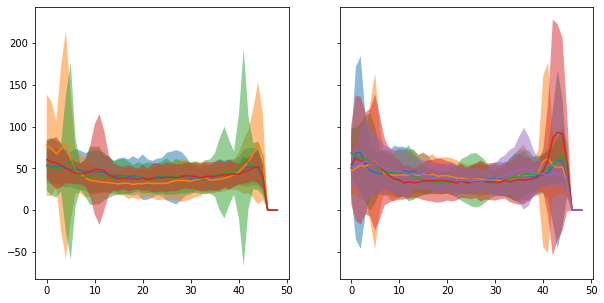

In [176]:
fig,ax = plt.subplots(1,2, figsize = (10,5),sharey=True)
x = np.arange(con_shuffle_hist_array.shape[-1])
for mean, std in zip(mean_shuffle_con, std_shuffle_con):
    ax[0].fill_between(x, mean+std, mean-std, alpha = 0.5)
    ax[0].plot(x, mean)
for mean, std in zip(mean_shuffle_exp, std_shuffle_exp):
    ax[1].fill_between(x, mean+std, mean-std, alpha = 0.5)
    ax[1].plot(x, mean)

In [177]:
# Calculate confidence intervals for each animal, for each timepoint
con_shuffle_hist_array = np.moveaxis(con_shuffle_hist_array,0,-1)
exp_shuffle_hist_array = np.moveaxis(exp_shuffle_hist_array,0,-1)

In [183]:
## Only looking for values HIGHER than control. NOT INTERESTED in below control

con_cis = np.zeros(con_shuffle_hist_array.shape[:-1], dtype = np.object)
con_cis_sig = np.zeros(con_cis.shape)
alpha = 0.05
wanted_percs = (100*(alpha/2),100*(1-(alpha)/2)) 
for animal_num,animal in enumerate(con_shuffle_hist_array):
    for time_num,time in enumerate(animal):
        ci_bounds = np.percentile(animal.flatten(), wanted_percs)
        con_cis[animal_num,time_num] = ci_bounds
        condition = con_tau_hist[animal_num,time_num] > ci_bounds[1]
        if condition:
            con_cis_sig[animal_num,time_num] = 1
            
exp_cis = np.zeros(exp_shuffle_hist_array.shape[:-1], dtype = np.object)
exp_cis_sig = np.zeros(exp_cis.shape)
wanted_percs = (100*(alpha/2),100*(1-(alpha)/2)) 
for animal_num,animal in enumerate(exp_shuffle_hist_array):
    for time_num,time in enumerate(animal):
        ci_bounds = np.percentile(animal.flatten(), wanted_percs)
        exp_cis[animal_num,time_num] = ci_bounds
        expdition = exp_tau_hist[animal_num,time_num] > ci_bounds[1]
        if expdition:
            exp_cis_sig[animal_num,time_num] = 1

Text(0.5, 1.0, 'Experimental')

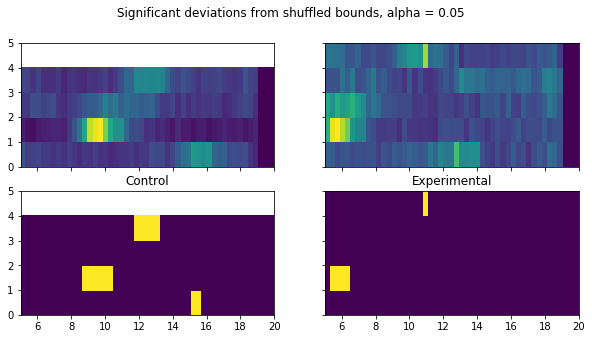

In [184]:
fig, ax = plt.subplots(2,2, figsize = (10,5),sharey=True, sharex=True)
ax[0,0].pcolormesh(bins_cut, range(con_tau_hist.shape[0]+1), con_tau_hist)#, aspect = 'auto')
ax[0,1].pcolormesh(bins_cut, range(exp_tau_hist.shape[0]+1), exp_tau_hist)#, aspect = 'auto')

plt.suptitle(f'Significant deviations from shuffled bounds, alpha = {alpha}')
ax[1,0].pcolormesh(bins_cut, range(con_tau_hist.shape[0]+1), con_cis_sig)#, aspect = 'auto')
ax[1,0].set_title('Control')
ax[1,1].pcolormesh(bins_cut, range(exp_tau_hist.shape[0]+1), exp_cis_sig)#, aspect = 'auto')
ax[1,1].set_title('Experimental')

In [185]:
## Only looking for values HIGHER than control. NOT INTERESTED in below control

con_cis = np.zeros(con_shuffle_hist_array.shape[:-1], dtype = np.object)
con_cis_sig = np.zeros(con_cis.shape)
alpha = 0.01
wanted_percs = (100*(alpha/2),100*(1-(alpha)/2)) 
for animal_num,animal in enumerate(con_shuffle_hist_array):
    for time_num,time in enumerate(animal):
        ci_bounds = np.percentile(animal.flatten(), wanted_percs)
        con_cis[animal_num,time_num] = ci_bounds
        condition = con_tau_hist[animal_num,time_num] > ci_bounds[1]
        if condition:
            con_cis_sig[animal_num,time_num] = 1
            
exp_cis = np.zeros(exp_shuffle_hist_array.shape[:-1], dtype = np.object)
exp_cis_sig = np.zeros(exp_cis.shape)
wanted_percs = (100*(alpha/2),100*(1-(alpha)/2)) 
for animal_num,animal in enumerate(exp_shuffle_hist_array):
    for time_num,time in enumerate(animal):
        ci_bounds = np.percentile(animal.flatten(), wanted_percs)
        exp_cis[animal_num,time_num] = ci_bounds
        expdition = exp_tau_hist[animal_num,time_num] > ci_bounds[1]
        if expdition:
            exp_cis_sig[animal_num,time_num] = 1

Text(0.5, 1.0, 'Experimental')

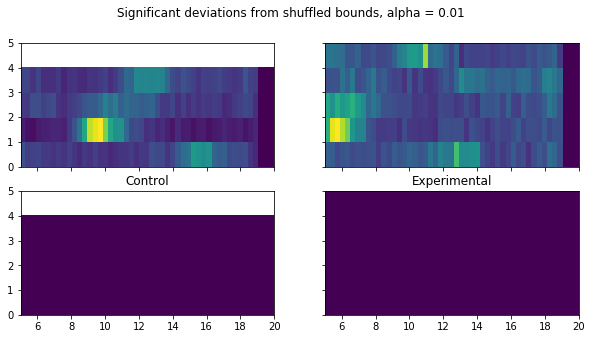

In [187]:
fig, ax = plt.subplots(2,2, figsize = (10,5),sharey=True, sharex=True)
ax[0,0].pcolormesh(bins_cut, range(con_tau_hist.shape[0]+1), con_tau_hist)#, aspect = 'auto')
ax[0,1].pcolormesh(bins_cut, range(exp_tau_hist.shape[0]+1), exp_tau_hist)#, aspect = 'auto')

plt.suptitle(f'Significant deviations from shuffled bounds, alpha = {alpha}')
ax[1,0].pcolormesh(bins_cut, range(con_tau_hist.shape[0]+1), con_cis_sig)#, aspect = 'auto')
ax[1,0].set_title('Control')
ax[1,1].pcolormesh(bins_cut, range(exp_tau_hist.shape[0]+1), exp_cis_sig)#, aspect = 'auto')
ax[1,1].set_title('Experimental')